# Overview

This is a CNN project for the **CheXpert** dataset consisting of labeled chest x-ray images.  There are over 200k x-rays in the dataset, each labeled with 14 findings.  The dataset in its raw form is both multi-label and multi-class in that each x-ray can have more than one label, and each of these labels can be one of 4 values (not mentuned, negative, uncertain and positive).

This project will reduce this dataset to about 137k images with 12 binary labels making this project just a multi-label CNN problem.

The dataset comes from the Stanford Machine Learning group and can be accessed via this link:
https://stanfordmlgroup.github.io/competitions/chexpert/

# Purpose

The purpose of this project is to build a framework that will easily allow repeatable runs of the dataset with variable parameters, images counts, models, etc.  Though it is always desired to produce the best possible accuracy, recall and precision in our predictions, the main goal of this project is to build the framework to more easily allow finetuning of model runs and not specifically finding the best configuration.  The hope is that by building a solid framework, a much deeper understanding of the working of CNN and all Neural Networks will be gained.

# Framework ERD

Below if a high level entity relationship diagram of how the framework was built:

![alt text](Diagrams/StandardTraining.png "Standard Training Overview") 


# Table of Contents

- [Goals](#Goals)
- [Educational Notebooks](#Educational_Notebooks)
- [Dataset](#Dataset)
- [Project Directory Structure](#Project_Directory_Structure)
- [Environments](#Environments)
- [EDA](#EDA)
- [CleanMetaData](#CleanMetaData)
	- [Intrinsic Leaks](#Intrinsic_Leaks)
	- [Target Interdependence](#Target_Interdependence)
	- [Imbalance](#Imbalance)
- [Modules](#Modules)
    - [CheXpertData Module](#CheXpertData_module)
    - [TrainingLoop and Metrics_Modules](#TrainingLoop_and_Metrics_Modules)
    - [Standard raining Module](#Standard_Training_Module)
- [Criterion and Optimizer](#Criterion_Optimizer)
- [Models](#Models)
	- [Custom](#Custom)
	- [ResNet](#ResNet)
	- [DenseNet](#DenseNet)
- [Results](#Results)
    - [Single Target Runs](#Single_Target_Runs)
    - [5 Targets](#5_Targets)
    - [All 12 Targets](#All_12_Targets)
    - [20 Epochs](#20_Epochs)
    - [5 Independent Models](#5_Independent_Models)
- [Conclusions](#Conclusions)
- [Future Areas of Exploration](#Future_Areas_of_Exploration)
- [Final Thoughts](#Final_Thoughts)

# Goals <a class="anchor" id="Goals"></a>

### Build a Framework for better Understanding

The primary goal of this project is to gain a deeper understanding of CNN and PyTorch.  There are already a lot of frameworks out there that do a lot more than what is built into this project, Keras and TensorBoard are some good examples.

But it is very difficult to get a good understanding of what is happening behind the scenes if the work is already done for you.  So in this project, preference is given to manual coding over pre-built packages.  

The coding mistakes and wrong assumptions made in this journey are invaluable.  In fact, these missteps are the key to better understanding.  Things like:
- Why can't I build the ROC curve from just my actual and predicted labels?
- Why is my accuracy over 90% when all my predictions are negative?
- Why can't I use pre-trained models with my grayscale images?
- How do I get my model's output to match my loss function?

There is no intention of making a framework that is better than ones already available.  Chances are for future CNN projects, I will use a lot more pre-built packages.  But the hope is the understanding gained with this project will allow me to leverage features and parameters in these packages much more accurately and efficiently.

### Code Reuse / Repeatable Model Runs

Jupyter Notebooks are a great way of combining code, visualizations and descriptive text in a single location.  But using notebooks for repeatable runs is not the most efficient approach.  You can copy/paste code or entire notebooks, but if you need to make a change, you have to change every notebook.  

Building Python modules to house the repeatable code is a much better approach and the route taken with this project.

Notebooks are used for specific runs, i.e. DenseNet vs. ResNet, Learning Rate 1e-4 vs. Learning Rate 1e-6.  But since most of the code is in modules, these notebooks (other than a couple of bootstrap blocks) contain only the model and training loop configurations.

### Model Goals

Though this project is more focused on understanding and building a framework, it is still important to have a target model goals to shoot for.

The order of importance for the model results are:
- Recall
- ROC Area Under the Curve
- Precision

This is somewhat arbitrary, but the thought is it would be better to suggest a false positive finding to a Radiologist then to miss a possible diagnosis.  Radiologists tend to make their own judgments about x-rays, but having a suggested finding might influence the doctor to spend more time analyzing these suggestions.

ROC is always important, but this is more of a true metric of how well the model performed since it is based on probabilities and not predictions.  But this might not be something the Radiologist would see.

We can easily make our recall values 100% by always predicting a positive finding.  So Recall is of no value if we don't keep the precision under control.


# Educational Notebooks <a class="anchor" id="Educational_Notebooks"></a>

### Linear Regression from Scratch using PyTorch

<a href="notebooks/Educational/Pytorch%20Linear%20Regression%20from%20Scratch.ipynb" >Pytorch Linear Regression from Scratch</a>

This notebook explored a simple linear regression using PyTorch.  A simple model is built from scratch using manually built linear and loss functions and a simple gradient descent class that inherits from torch.optim.Optimizer.

This notebook then goes into polynomial regression to predict the coefficients of a 3rd degree polynomial.
    

### Autograd package in PyTorch    
<a href="notebooks/Educational/Pytorch%20Automatic%20Differentiation.ipynb" >Pytorch Automatic Differentiation</a>

This notebook looks at the torch.autograd package and explores how PyTorch implements automatic differentiation.  Various functions including polynomials are looked at and how the computational graphs along with the chain rule to see how forward and backward passes determine the gradient of the function with respect to the input variables.

# Dataset <a class="anchor" id="Dataset"></a>

The raw dataset comes as a set of images along with a csv index file.  There is one row in the csv file for each x-ray.
There are both train and validation dataset with 223,415 and 234 images respectively.  Since the validation set was so small, only the train dataset was used.  These 223,415 images were randomly split into train and val during the model runs.

The csv contains some tabular features such as sex and age, aspectes of the image such as orientation and view, and a path for the image file.

The csv also contains the 14 labels:
- Enlarged_Cardiomediastinum
- Cardiomegaly
- Lung_Opacity
- Lung_Lesion
- Edema
- Consolidation
- Pneumonia
- Atelectasis
- Pneumothorax
- Pleural_Effusion
- Pleural_Other
- Fracture
- No Finding
- Support Devices (i.e. pacemakers)

Any image can have any number of labels making this a multi-label dataset.  i.e. An x-ray can show both Pleural Effusion and Cardiomegaly.

Also, each of these labels can have one of 4 values:
- Not Mentioned = Null
- Negative = -1
- Uncertain = 0
- Positive = 1

How the x-ray was taken is stored in 2 columns, "Frontal/Lateral" and "AP/PA".  Lateral x-rays are taken from the patient's side.  AP/PA stands for Anterior and Posterior.  AP means the x-rays entered the patient's from and exited out of the patient's back and PA is the opposite.  

From the image path, we can parse out a PatientID and StudyID.  A study is a set of x-rays taken at the same time.  A study can have just a single frontal x-ray, a single lateral x-ray or have both a frontal and lateral set of x-rays.
Patients who only had one set of x-rays will have only a StudyID of 1.  Patients with multiple studies will have StudyIDs 1,2,3,4,....  The max number of studies for a single patient in this dataset was 72.

#### Competition
CheXpert was set up as a competition, but only 5 of the 12 targets are included:
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural_Effusion']

So many of model runs will only focus and/or train only on these 5 labels.

*Note: This project is NOT intended to enter this competition*

# CheXpert User Agreement

The images in this dataset cannot be made publically available.  Because of this, the images are not included in this project.  But you can obtain the dataset yourself and run this code.  You may need to adjust the working directories in the top bootstrap code block at the start of every notebook.

*Note:  See Hierarchical Path below for special directory structure*

# ═════════════════════════
# Project Directory Structure <a class="anchor" id="Project_Directory_Structure"></a>


## <a href="data" >data</a>

*   **<a href="data/raw" >raw</a>**
    -   Holds metadata csv files from CheXpert
    -   Holds download x-ray images

*    **<a href="data/intermediate" >intermediate</a>**
    -   Holds Clean DF

*    **<a href="data/d0" >d0</a> through <a href="data/d49" >d49</a>**
    -   Holds same x-ray images, but in a hierarchical directory structure for CoLab

## <a href="modules" >modules</a>

* **<a href="modules/lib" >lib</a>**
    -   **<a href="modules/lib/CheXpertData.py" >CheXpertData.py</a>**
        * Clean Meta Data (DataFrame)
        * PyTorch DataSet (Subclass of torch.utils.data.Dataset)
        * PyTorch DataLoaders
    -   **<a href="modules/lib/Metrics.py" >Metrics.py</a>**
        * Holds results passed to it via training
        * Displays metrics of the run along with things like ROC curves
    -   **<a href="modules/lib/StandardTraining.py" >StandardTraining.py</a>**
        * Runs the training loop with overridable default parameters
        * Allow consistency between different run
        * ModelLoop class - Run multiple combinations of parameters in same notebook
    -   **<a href="modules/lib/TrainingLoop.py" >TrainingLoop.py</a>**
        * Runs the training
        * Pass in, NN, cuda device, optimizer, loss function and Metrics class described above

* **<a href="modules/models" >models</a>**
    -   **<a href="modules/models/CustomPneumonia.py" >CustomPneumonia.py</a>**
        * Custom build CNN model
        * Intended to be more educational rather than effective
        * Goal was to make sure:
            - Shapes match between each layer and between convolution and fully connected layers
            - Ability to calculate the number of trainable parameters
    -   **<a href="modules/models/DenseNet.py" >DenseNet.py</a>**
        * A fairly standard structure of DenseNet (see below for more details)
    -   **<a href="modules/models/ResNet.py" >ResNet.py</a>**
        * ResNet_GrayScale
            - Uses torchvision.models.resnetXX models
            - Overrides conv1 to take in 1 input channel
            - Add fully connected layer at end of forward to reduce the 1000 changes to the desired output length
            - Registers a forward hook to add dropout2d is drop_out_precent is passed in
        * ResNet_Pretrained
            - Uses torchvision.models.resnetXX models with pretrained=True
            - Keeps input channels as 3
            - Add fully connected layer at end of forward to reduce the 1000 changes to the desired output length
            - Registers a forward hook to add dropout2d is drop_out_precent is passed in
            - Uses torch.repeat_interleave to duplicate the 1 grayscale channel to 3 channels

## <a href="notebooks" >notebooks</a>
-   **<a href="notebooks/Educational" >Educational</a>** - Two notebooks exploring PyTorch functionality
    * <a href="notebooks/Educational/Pytorch%20Linear%20Regression%20from%20Scratch.ipynb" >Pytorch Linear Regression from Scratch</a>
    * <a href="notebooks/Educational/Pytorch%20Automatic%20Differentiation.ipynb" >Pytorch Automatic Differentiation</a>
-   **<a href="notebooks/Kaggle%20Pneumonia" >Kaggle Pneumonia</a>**
    * Very early work with CNN on Kaggle Pneumonia chest x-rays
    * Basis of CustomPneumonia model
-   **<a href="notebooks/ModelLoop" >ModelLoop</a>**
    * Notebooks that run combinations of different modes and/or parameters with a reduced dataset
-   **<a href="notebooks/ModelRuns" >ModelRuns</a>**
    * Notebooks that train a single model and parameters
    * **<a href="notebooks/ModelRuns/saved" >saved</a>**
        - Holds the pickle serialization of the model runs
        - *Note: Due to size constraints, this folder was not committed to GitHub*
-   **<a href="notebooks/Support%20Notebooks%20for%20Modules" >Support Notebooks for Modules</a>**
    * The workspace used to help build the modules
    * <a href="notebooks/Support%20Notebooks%20for%20Modules/CheXpertData_NB.ipynb" >CheXpertData_NB</a>
    * <a href="notebooks/Support%20Notebooks%20for%20Modules/EDA.ipynb" >EDA</a>
    * <a href="notebooks/Support%20Notebooks%20for%20Modules/HierarchicalPath.ipynb" >HierarchicalPath</a>
    * <a href="notebooks/Support%20Notebooks%20for%20Modules/Metrics%20and%20Training%20Loop.ipynb" >Metrics and Training Loop</a>
    * <a href="notebooks/Support%20Notebooks%20for%20Modules/Metrics_NB.ipynb" >Metrics_NB</a>
    * <a href="notebooks/Support%20Notebooks%20for%20Modules/ModelLoop_NB.ipynb" >ModelLoop_NB</a>
    * <a href="notebooks/Support%20Notebooks%20for%20Modules/Oversampling.ipynb" >Oversampling</a>
    * <a href="notebooks/Support%20Notebooks%20for%20Modules/StandardTraining_NB.ipynb" >StandardTraining_NB</a>
    * <a href="notebooks/Support%20Notebooks%20for%20Modules/TrainingLoop_NB.ipynb" >TrainingLoop_NB</a>

# ═════════════════════════

# Environments <a class="anchor" id="Environments"></a>

This project is intended to run both locally with GPU and on Google CoLab.  Locally (GEFORCE RTX 2080 - 8GB), most models run very well, but might need to adjust the batch size down for some. The same notebooks can also run on Google CoLab without any changes.  The bootstrap code block at the top of the notebooks determines the working directory on both environments and sets the PyTorch device to cuda. 

Most if not all of the notebooks in this project were completed locally.  Though CoLab has the advantage from a computational power perspective, it is very slow accessing the image files.

## Hierarchical Directory

To see how to implement the hierarchical path, see: 
<a href="notebooks/Support%20Notebooks%20for%20Modules/HierarchicalPath.ipynb" >Hierarchical Path Notebook</a>

In Google CoLab, the images need to be accessible.  Since the dataset is not public and there is no API to retrieve the images, you need to mount a drive in order for CoLab to get access to these images.  In the CoLab environment, the images are stored on Google Drive.  There are plenty of posts on how to mount a drive in this way.

But the directory structure on Google Drive is not the same as your local file system.  Since Google Drive is primarily a web based application, it cannot navigate directly to a file via a path.  So every time you give it a path, a call must be made to obtain an ID for the folder and or path before it can access it.  That means that every image read during the training loop must do a lookup of the item ID first.

With over 200k files, the training loop would have to find the ID out of 200,000 IDs.  But it has to do this for every image, so the number of lookups in a single epoch would be 200k X 200k which is over 40 billion lookups.

In fact, just uploading the images to Google Drive was extremely slow.  After several days of upload, the process was still not done.  A silent timeout error was occuring most of the time so many of the uploaded images didn't get to the drive.  See top of HierarchicalPath.ipynb (link above).

After a fair amount of research, the approach taken to resolve this was to copy the files into a hierarchical folder structure where no more than 50 items existed in any one folder.  To get the proper ID, there are only 3 ID lookups, each with only 50 items.  So instead of 200k lookup, we only needed to do 150.  

Though this did resolve the timeout issue, the training loops were still much slower than running locally.  So all models were run locally as long as there was enough memory to support it.

*Note:  The hierarchical directories greatly helped the upload process!*

# EDA  <a class="anchor" id="EDA"></a>

Bootstrap code to set working directory and mount drive in CoLab

In [1]:
import sys
import os, os.path

sys.path.append(os.path.join(os.getcwd() ,'/modules'))
root_path = "C:/git/Springboard-Public/Capstone Project 2/"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/My Drive/Capstone Project 2/"

print('Current Working Dir: ', os.getcwd())
print('Root Path: ', root_path)

# We need to set the working directory since we are using relative paths from various locations
if os.getcwd() != root_path:
  os.chdir(root_path)

Current Working Dir:  C:\git\Springboard-Public\Capstone Project 2
Root Path:  C:/git/Springboard-Public/Capstone Project 2/


In [2]:
import sys
import os, os.path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from modules.lib.CheXpertData import CleanMetaData
from modules.lib.TrainingLoop import *
from modules.lib.Metrics import *
from modules.lib.StandardTraining import *

from modules.models.CustomPneumonia import CustomPneumoniaNN
from modules.models.ResNet import ResNet_GrayScale, ResNet_PreTrained
from modules.models.DenseNet import DenseNet

from torchsummary import summary

%matplotlib inline

# Data Cleansing

To see the process of data cleaning, please go to the supporing notebook: 
<a href="notebooks/Support%20Notebooks%20for%20Modules/EDA.ipynb" >EDA Support Notebook</a>

To see the module, please go to:
<a href="modules/lib/CheXpertData.py" >CheXpertData.py</a>

### Frontal only
To reduce the complexity of learning and to reduce the overall number of images, only frontal views were included.  

### Multiple Studies
To prevent a patients with serial studies biasing the results, only the first 4 studies were included in the clean dataset. 

These 2 filters reduced the image count from 223,415 to 131,748.

    df_reduced = df[
                (df.View == 'Frontal') & # Don't show x-rays from the side
                (df.StudyID < 5) & # Don't include more than 4 studies for a single patient
                ((df.Orientation == 'AP') | (df.Orientation == 'PA')) # Don't show Left or Right Lateral
                ]

### 12 Targets
Two targets were removed from the original 14:
- No Finding
- Support Devices

The first was removed for the same reason we do with one-hot encoding.
Support Devices (i.e. Pacemakers, LVAD, etc.) was removed since these findings could be considered more of a feature than a diagnosis.

### Binary Labels
To reduce the complexity of combining multi-label and multi-class classifications, the labels were converted into Boolean values.

- Not Mentioned = 0
- Negative = 0
- Uncertain = 0
- Positive = 1

# CleanMetaData <a class="anchor" id="CleanMetaData"></a>

In [3]:
metaData = CleanMetaData()
target_columns = metaData.target_columns
df_clean= metaData.getCleanDF()
display(df_clean)

,PatientID,StudyID,Age,Sex_Male,Sex_Unknown,Orientation_PA,Support Devices,Image_Path,Hierarchical_Path,Enlarged_Cardiomediastinum,...,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture
ImageID,,,,,,,,,,,,,,,,,,,,,
0,1,1,68,0,0,0,1.0,data/raw/train/patient00001/study1/view1_front...,data/d0/d1/i0.jpg,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,87,0,0,0,0.0,data/raw/train/patient00002/study2/view1_front...,data/d1/d2/i1.jpg,0,...,1,0,0,0,0,0,0,0,0,1
2,2,1,83,0,0,0,0.0,data/raw/train/patient00002/study1/view1_front...,data/d2/d2/i2.jpg,0,...,1,0,0,0,0,0,0,0,0,1
4,3,1,41,1,0,0,0.0,data/raw/train/patient00003/study1/view1_front...,data/d4/d3/i4.jpg,0,...,0,0,1,0,0,0,0,0,0,0
5,4,1,20,0,0,1,0.0,data/raw/train/patient00004/study1/view1_front...,data/d5/d4/i5.jpg,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,64537,2,59,1,0,0,0.0,data/raw/train/patient64537/study2/view1_front...,data/d9/d37/i223409.jpg,0,...,0,0,0,0,0,0,0,1,0,0
223410,64537,1,59,1,0,0,0.0,data/raw/train/patient64537/study1/view1_front...,data/d10/d37/i223410.jpg,0,...,0,0,0,0,0,0,0,0,0,0
223411,64538,1,0,0,0,0,0.0,data/raw/train/patient64538/study1/view1_front...,data/d11/d38/i223411.jpg,0,...,0,0,0,0,0,0,0,0,0,0


# Intrinsic Leaks <a class="anchor" id="Intrinsic_Leaks"></a>
Though there is nothing we can do about this, there are intrinsic leaks in the images that we should be aware of.

In-patients are much more likely to have positive findings then out-patients, especially out-patient routine screening x-rays. In-patient x-rays oftentimes can have leaks in the images.  ECG leads, IVs and gown snaps are often present.  Higher acuity patients will oftentimes have their x-rays taken in bed with AP orientation.  PA is preferred since it does not tend to exaggerate the cardiac silhouette.  Also, it might be harder to properly align very sick patients.  All of these can leak features more common in positive diagnoses.  

### X-Ray with ECG Leads indicating an In-patient

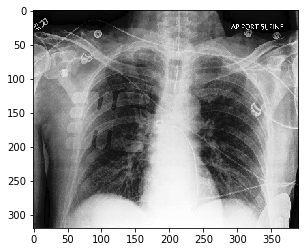

In [4]:
img = metaData.displayImage(123)
imgplot = plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

# Target Interdependence <a class="anchor" id="Target_Interdependence"></a>
Though each of the 12 labels can be found independently of each other, it is very common to have findings that correlate with other findings.  For example, it would be more common to find atelectasis in patients with pneumonia or pleural effusions.  Rib fractures may make it painful to ambulate potentially leading to other lung diseases such as atelectasis or pneumonia.

Patients with high comorbidities may have several of these findings.  Diagnoses like Cardiomeglia tend to not be transient and can persist for years.  These longer term diseases may or may not correlate to other pathologies.

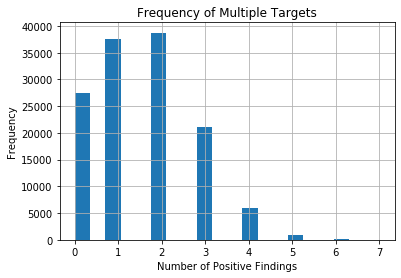

In [5]:
ax = df_clean.iloc[:, -12:-1].sum(axis=1).hist(bins=20) 
ax.set_title('Frequency of Multiple Targets')
ax.set_xlabel('Number of Positive Findings')
ax.set_ylabel('Frequency')
plt.show()

# Imbalance <a class="anchor" id="Imbalance"></a>

One of the biggest challenges is the imbalance of the 12 targets.  The most frequent target, Lung Opacity, occurs in about 45% of the x-rays.  But as you can see below, the majority of the labels have less than a 15% positive occurrence.

This imbalance along with non-independent multi-label classification will comprise the majority of the obstacles for this project.


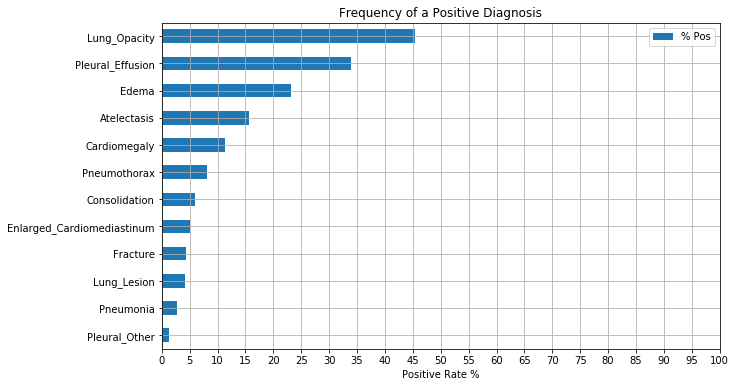

In [6]:
ax =pd.DataFrame(df_clean.iloc[:, -12:].sum() / len(df_clean) * 100, 
             columns=['% Pos']).sort_values('% Pos').plot.barh(figsize=(10,6))
ax.set_title("Frequency of a Positive Diagnosis")
ax.set_xlabel("Positive Rate %")
ax.set_xlim(0, 100)
ax.set_xticks(range(0, 101, 5))
ax.grid()

# Modules  <a class="anchor" id="Modules"></a>



# CheXpertData module (DataFrame, Dataset and DataLoaders)  <a class="anchor" id="CheXpertData_module"></a>

Please go to the supporting notebook for these classes: 
<a href="notebooks/Support%20Notebooks%20for%20Modules/CheXpertData_NB.ipynb" >CheXpertData Notebook</a>

To see the module, please go to:
<a href="modules/lib/ChextXRayImages.py" >ChextXRayImages</a>

### CleanMetaData (DataFrame)
In addition to the data cleansing, the CleanMetaData class performs 2 critical functions:
- Randomly select rows from metadata 
    * This allow us to do model runs with reduced size for debugging and parameter evaluation
- Splits the rows randomly into train and validation
    * This is be done after the the dataset has been reduced from the above step
    * The balance is checked between train and val
        - For each feature, the % positives is found
        - If the difference in this percentage between train and val exceeds the default 2%, a warning is displayed
        - The warning lists all features that have an imbalance
        - This is often seen with very low row counts
        - See **Warnings** section of <a href="notebooks/Support%20Notebooks%20for%20Modules/EDA.ipynb#Warnings">EDA</a>:


### Dataset
This is a subclass of torch.utils.data.Dataset.  The main purpose of the derived class to use the clean metadata to get the image path, the ground truth for the 12 targets and the ImageID index value of the image.

One the init method, lists are created to hold the above data.  The clean dataframe is walked to load these lists.

In the getitem method, 3 tasks are performed:
- Get the ImageID
- Pull the PIL image from the image path and apply any transformations
- Build a vector of the target values

The output of the getitem is a dictionary with 3 keys, 'id', 'img' and 'labels'.  During training, this dictionary has to be parsed manually before feeing the images into the model.

### Loaders

This class is used to obtain instances of torch.utils.data.DataLoader.  A single loader for all images in the clean dataframe can be returned, but most of the time 2 loaders are returned for train and validation.

This class uses the other 2 classes in the CheXpertData module, **CleanMetaData** and **Dataset**.  Because of these, these 2 classes are usually never called directly.

On instantiation of this class, you pass in the following parameters:

    def __init__(self, 
                 image_width=320,
                 image_height=320,
                 affineDegrees=5, 
                 translatePrecent=0.05, 
                 shearDegrees=4, 
                 brightnessJitter=0.2, 
                 contrastJitter=0.1, 
                 augPercent=0.2,
                 observation_min_count = None,
                 target_columns=None):     

The image shape parameters are self explanatory.  The next 5 parameters are used to add image augmentations to the train transformation sequence (RandomAffine and ColorJitter).  The augPercent is the percentage that these 2 augmentation types are applied to the dataset.

The observation_min_count parameter is for oversampling (see below).  

The target_columns let you reduce the labels of the dataset.  
If you pass in:
- **training_columns = ['Pleural_Effusion', 'Edema']**-

only these 2 labels will be used for training and metrics.

In addition, the pixel mean and standard deviation are hard coded with values found in the support notebook:

        self.pixel_mean = 0.5064167
        self.pixel_sd = 0.16673872


The most common method used in this class is:
    
    def getDataTrainValidateLoaders(self, batch_size=64, 
                                    val_percent = 0.2, 
                                    n_random_rows = 0):
                                    
This method returns a tuple of (train, val) data loaders with the total size and split percent passed in.                                    
        
#### Oversampling
The Loaders class also does the oversampling. We cannot use tools like SMOTE for this.  Our features are embedded in the images and are derived via the convolutions during training.  Because of this, we have nothing metrizable to do a nearest neighbors concept.  

But we do have the combination of targets.  There are 802 unique ground truth vectors in our clean dataframe.  If you look at the frequencies, you see the typical exponential decal pattern.  The all negative vector [0,0,0,0,0,0,0,0,0,0,0,0] is the most common followed by "Lung Opacity only" and "Lung Opacity, Pleural_Effusion only".  The counts very quickly drop to very low numbers after the first few combinations.

So the approach to oversampling is to group rows by unique target vectors.  A parameter **observation_min_count** can be passed into the class.  This parameter is used to find any target vector who has less observations than this threshold.  Then the observations in this group are sampled with replacement to add duplicate rows to the dataframe to reach the min count required.

Please go to the supporting notebook that help derived this method: 
<a href="notebooks/Support%20Notebooks%20for%20Modules/Oversampling.ipynb" >Oversampling Notebook</a>


In [7]:
total_rows = df_clean.shape[0]
df_combined = pd.DataFrame(df_clean.PatientID)
df_combined['Combined_Targets'] = ''
for c in target_columns:
    df_combined['Combined_Targets'] = df_combined['Combined_Targets'] + df_clean[c].map({-1:'N', 0:'0', 1:'P'})
   
df_combinations = pd.DataFrame(df_combined.groupby(['Combined_Targets']).count())
df_combinations.columns = ['Frequency']
df_combinations['Percent'] = df_combinations.Frequency / total_rows
print(f'Total Unique Target Combinations {df_combinations.shape[0]:,}\n')
df_combinations = df_combinations.sort_values(['Frequency'], ascending=False)
print('\n'.join(target_columns))
display(df_combinations.head(15))
display(df_combinations.tail(5))

Total Unique Target Combinations 802

Enlarged_Cardiomediastinum
Cardiomegaly
Lung_Opacity
Lung_Lesion
Edema
Consolidation
Pneumonia
Atelectasis
Pneumothorax
Pleural_Effusion
Pleural_Other
Fracture


,Frequency,Percent
Combined_Targets,,
000000000000,25805,0.195866
00P000000000,12816,0.097277
00P000000P00,10586,0.080350
0000P0000000,4834,0.036691
000000000P00,4770,0.036205
00P0P0000P00,4584,0.034794
00P0P0000000,4116,0.031241
0000000P0000,3409,0.025875
00000000P000,2900,0.022012


,Frequency,Percent
Combined_Targets,,
0P0000P000P0,1,0.000008
0P0000P0000P,1,0.000008
P00P0P000000,1,0.000008
0P000000PP0P,1,0.000008
PPPPP0P00P00,1,0.000008


# TrainingLoop and Metrics Modules  <a class="anchor" id="TrainingLoop_and_Metrics_Modules"></a

Both of the modules hold a single class with the same name.

To see the modules, please go to:

<a href="modules/lib/TrainingLoop.py" >TrainingLoop</a>

<a href="modules/lib/Metrics.py" >Metrics</a>

Please go to the supporting notebooks, please go to: 

<a href="notebooks/Support%20Notebooks%20for%20Modules/Metrics_NB.ipynb" >Metrics Notebook</a>

<a href="notebooks/Support%20Notebooks%20for%20Modules/TrainingLoop_NB.ipynb" >TrainingLoop Notebook</a>

<a href="notebooks/Support%20Notebooks%20for%20Modules/Metrics and Training Loop.ipynb" >Metrics and Training Loop Notebook</a>

The TrainingLoop performs the training epics and passes the results to an instance of the Metrics object.  The Metrics object holds the probabilities and predictions for each epoch run.  It also displays and saves this data.  The Metrics instance can be used in the training loop to display selected results after each epoch.  It also allows you to display all metrics including epoch by epoch plots after training is completed.


### TrainingLoop

This is a relatively simple class.  On instantiation, you pass in the device (CPU or CUDA), NN, optimizer and loss functions and an instance of the Metrics class.

    def __init__(self, device, net, optimizer, criterion, metrics):
    
The **train** method gets passed in the number of epochs and the train and validation data loaders.

    def train(self, num_epochs, train_loader, val_loader):

For each epoch, both the training and validation loaders are enumerated.  The size of the batches is a parameter in the 2 data loaders, so the train code is unaware of this value.  The train() and eval() methods are called on the model for train and val respectively.  Only the train gets back propagation while val calls torch.no_grad().

The main calls in the epoch loops are below:

    self.net.train()
    for i, data in enumerate(train_loader, 0): 
        ids, inputs, labels, outputs = self.processBatch(data)
        self.metrics.appendEpochBatchData(ids, outputs)
        self.epoch_loss += self.backProp(outputs, labels)

    ...

    self.net.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):         
            ids, inputs, labels, outputs = self.processBatch(data, is_validation=True)
            self.metrics.appendEpochBatchData(ids, outputs, is_validation=True)        
        
The processBatch method is:

    def processBatch(self, data, is_validation=False):

        # Convert output from loader
        ids, inputs, labels = self.parseLoaderData(data)

        if not is_validation:
            # zero the parameter gradients
            self.optimizer.zero_grad()

        # Get outputs from Model
        outputs = self.net(inputs)

        return ids, inputs, labels, outputs 
                
Since the dataset subclass returns a dictionary with the getitem method, the values are parsed with:

    ids, inputs, labels = data['id'], data['img'], data['labels']
    # move data to device GPU OR CPU
    inputs, labels = inputs.to(self.device), labels.to(self.device)
    
The inputs variable is the transformed images for the batch.  
The shape of this tensor is **[batch_size, channels, height, width**]  

The outputs tensor from the net call has a shape of **[batch_size, target_count]**.  There is no activation function on the last **nn.Linear** layer in the models, so the outputs are raw numbers between $-\infty$ and $\infty$.  So the assumption is that the loss function will do the squashing of this output (see Criterion below).

The metrics.appendEpochBatchData(ids, outputs) hands off the batch results to the Metrics object.

For train, backprop is done with this method:

    def backProp(self, outputs, labels):
        loss = self.criterion(outputs, labels)
        loss.backward()
        self.optimizer.step()
        return loss.item()   


### Metrics

#### Some Metric Background
This class is key to understanding how our model is doing, both on completion and for each epoch.

Looking at multiple values after each epoch is critical in this dataset.  Since most targets are close to 90% negative, chances are you are going to get very high accuracy scores.  The model is trying to predict the positive labels.  A bad model that can't do this will still get ~90% of the predictions right.

There are also multiple ways to look at accuracy for multi-label data.  You can say the prediction is accurate only if all 12 targets are correct.  This is a very high bar and doesn't reflect the effectiveness of the model.  If every image correctly identifies 11 out of 12 labels, the accuracy would still be 0% since no image got all 12 correct.  This type of accuracy score is returned with **sklearn.metrics.accuracy_score**.

You can also use the number of correct predictions divided by the total number of predictions (1-Hamming score).  
This type of accuracy score is returned with **1 - sklearn.metrics.hamming_loss**.

Butthe  Hamming approach gets us back to the 90% accuracy problem we just described above.  The bottom line is that accuracy is probably not the best way to access the model effectiveness.  

#### Model probability vs. predictions
We need to be sure of the differences between these two before we discuss the next metric scores.

The CNN model outputs produce one value for each target.  These values can be anything from from $-\infty$ to $\infty$.  So take these outputs and squash them using the sigmoid function to produce probabilities between 0 and 1.  

To get a prediction of either 1 or 0, we take this probability and check it against a threshold (usually 0.50).  If the prob is >= 0.5, we predict positive or 1.  If below the threshold, we predict negative or 0.

The end result is predictions make a single assertion about an image, i.e. either it is a dog or it is not.  But the predictions don't show how close we got.  i.e. it is not a dog since the prob was 0.49999.

Probabilities show how close we got. Scores based on probabilities more accurately reflect effectiveness of our model.  But if your desired output is a single assertion, prediction based scores are probably better.

#### Combined Metrics vs. Itemized Metrics
Like we tried to do above with accuracy, we can combine the probabilities and/or predictions of the 12 labels into a single score, so simply show the score 12 times, one for each target.  We tend to prefer a single score since it is easier to make a statement about the effectiveness of the entire model.  But taking some kind of average of these 12 scores can be very misleading.  A bad prediction for a few targets can suggest the model is a poor performer.  

For this reason, the itemized scores will be the primary approach for accessing model performance.

#### Four Primary Sores

- Recall (Sensitivity)
- Precision
- ROC AUC
- Average Precision

The first 2 are based only on the predictions and do not take probabilities into account.  
- $Recall = \frac{TP}{TP + FN}$ - What % of the true positives were found
- $Precision = \frac{TP}{TP + FP}$ - What % of the true predictions were correct

The last 2 scores are based on probability. Because the scores are probabilities, this gives us "many" values as opposed to only the 4 prediction values (TP. TN, FP, FN).  i.e. a TP can have many different probabilities (.12, .45, .78, .98, .87. ...).  These floats allow us to plot both the Receiver Operator Curves (ROC) and the Precision/Recall curves.  To get a value from these curves, we take the area under the curve.  

If our recall is 50%, half the actual positives would be true positives and half would be false negatives.
If all the false negatives have a probability of 0.4999, and all the true post positives have a probability of 0.9999, then the ROC AUD and Average Precision would be much greater than 50%.

Since our stated model goal was to try to get the Recall scores, this is the primary score used to determine the model's success.  But we can't just look at a single value.   A good recall with a bad precision means we won't miss any actual positives, but we won't be able to trust these predictions very much.  We can simply make the model always predict Positive for all observations.  This would give us a 100% Recall, but a very low Precision.


### Metrics Class

To see the Metrics modules, please go to:

<a href="modules/lib/Metrics.py" >Metrics</a>

Please go to the supporting notebook, please go to: 

<a href="notebooks/Support%20Notebooks%20for%20Modules/Metrics_NB.ipynb" >Metrics Notebook</a>

<a href="notebooks/Support%20Notebooks%20for%20Modules/Metrics and Training Loop.ipynb" >Metrics and Training Loop Notebook</a>



On instantiation, this class is given the target columns, the actual label values, and optionally the target thresholds.

    def __init__(self, target_columns, train_actual, val_actual, target_thresholds=None, ...

The training loop passes the model outputs after each batch iteration.  It also passes the set of ImageIDs so that these results can be matched back to the original metadata.  

    def appendEpochBatchData(self, ids, outputs, is_validation=False):

This batch data is stored temporarily in a dictionary of ID:Output.  Each batch appends to this dictionary until the epoch is done.  Then the dictionaries for train and val are converted to a dataframe and appended to the prediction and probability histories:

    def closeEpoch(self, epochNumber, is_validation=False):
        if is_validation:
            self.df_val_prediction = self.getPredictionDataFrame(self.epoch_val_predictions)
            self.val_prediction_hx[epochNumber] = self.df_val_prediction.copy()
            self.epoch_val_predictions = {}

            self.df_val_probability = self.getProbilityDataFrame(self.epoch_val_probabilities)
            self.val_probability_hx[epochNumber] = self.df_val_probability.copy()
            self.epoch_val_probabilities = {}
        else:
            self.df_train_prediction = self.getPredictionDataFrame(self.epoch_train_predictions)
            self.train_prediction_hx[epochNumber] = self.df_train_prediction.copy()
            self.epoch_train_predictions = {}

            self.df_train_probability = self.getProbilityDataFrame(self.epoch_train_probabilities)
            self.train_probability_hx[epochNumber] = self.df_train_probability.copy()
            self.epoch_train_probabilities = {}


The Metrics class assumes the final output of the model has not been passed through any activation function (see Criterion below).  So the Metrics class need to generate probabilities and predictions from these raw outputs:

    def getPredictionsFromOutput(self, outputs):
        """
        We are using BCEWithLogitsLoss for our loss
        In this loss function, each label gets the sigmoid (inverse of Logit) before the CE loss
        So our model outputs the raw values on the last FC layer
        This means we have to apply sigmoid to our outputs to squash them between 0 and 1
        We then take values >= .5 as Positive and < .5 as Negative (or optional target thresholds)
        """

        probabilities = torch.sigmoid(outputs.data) 
        predictions = probabilities.clone()
        
        #We need to make sure all tensors are in the same memory space
        if self.target_thresholds.device != predictions.device:
            self.target_thresholds = self.target_thresholds.to(predictions.device)
        
        predictions[predictions >= self.target_thresholds] = 1 # assign 1 label to those with gt or equal to threshold
        predictions[predictions < self.target_thresholds] = 0 # assign 0 label to those with less than threshold   
        
        return probabilities, predictions   

The target thresholds are optional with default values of 0.5:

        if target_thresholds is None:
            #Default thresholds for all targets is .5
            self.target_thresholds = np.ones(len(self.target_columns)) * .5
        else:
            #Custom Thresholds
            #i.e. set Edema threshold to .2.  If Edema probability >= .2, prediction = 1
            self.target_thresholds = target_thresholds

These thresholds are a trick.  This is done entirely in the Metrics class and has nothing to do with the loss function.  So the predictions displayed in this class are affected, but training and weight adjustments are completely unaware of these thresholds.  

At the end of the epoch, the current dataframes are used to build the scores and optionally displayed in the training loop display.  This display method has many different parameters to allow you to pick which items to display:

    def displayMetrics(self, 
                       metricDataSource = MetricDataSource.Both, #train, val, both
                       showCombinedMetrics=True,
                       showMetricDataFrame=True,
                       showROCCurves=True,
                       showPrecisionRecallCurves=True,
                       include_targets=None,
                       combinedAverageMethod='samples',
                       gridSpecColumnCount=4,
                       gridSpecHeight=3,
                       gridSpecWidth=20):

The include_targets parameter lest you display only a subset of the targets.  For example, instead of showing all 12 label scores after each epoch, you can just display the 5 targets identified in the CheXpert competation.

At the end of training, the last epoch results can be displayed.  The display for the epoch and the final results are the same method (displayMetrics), but with different display options passed in.

The Metrics class also has a method (displayEpochProgression) to display plots by epoch.  i.e. display the progression of the recall score plotted against the epoch number.  

    def displayEpochProgression(self, 
                                showResultDataFrames=False,
                                showAccuracyProgression=True,
                                showRecallProgression=True,
                                showPrecisionProgression=True,
                                showF1Progression=True,
                                showROCAUCProgression=True,
                                showAvgPrecisionProgression=True,
                                include_targets=None):



## Standard Training Module <a class="anchor" id="Standard_Training_Module"></a>

This module is the glue for all other modules.  

To see the module, please go to:

<a href="modules/lib/StandardTraining.py" >StandardTraining</a>

Please go to the supporting notebook, please go to: 

<a href="notebooks/Support%20Notebooks%20for%20Modules/StandardTraining_NB.ipynb" >Standard Training Notebook</a>

There are 2 classes in this module, StandardTraining and ModelLoop.

### StandardTraining Class

![alt text](Diagrams/StandardTraining.png "Standard Training Overview") 

Since this is the gateway class, the constructor takes in a lot of optional parameters:

        def __init__(self,   number_images, 
                         batch_size, 
                         learning_rate, 
                         num_epochs,
                         device, 
                         net,
                         epoch_args='standard',
                         use_positivity_weights=False, 
                         image_width = 320,
                         image_height = 320,
                         affineDegrees=5, 
                         translatePrecent=0.05, 
                         shearDegrees=5, 
                         brightnessJitter=0.2, 
                         contrastJitter=0.1, 
                         augPercent=0.2,
                         observation_min_count=None,
                         l2_reg=0,
                         loss_reduction='mean',
                         target_columns=None,
                         target_thresholds=None,
                         save_path=None,
                         net_name=None,
                         net_kwargs=None):
                         
These parameters include options for the data loaders, metrics and training loop classes as well as the model itself.  There are also options needed for the loss function, optimizer and persistence. 

The main purpose of the StandardTraining class is to allow repeatable model runs using the exact same default values.  So if you want to compare 2 runs with and without L2 regularization, you only need to override one parameter.  All the other parameters will be the same since the default values are used.

The basic steps involved are shown below:

![alt text](Diagrams/StandardTrainingSteps.png "Standard Training Steps") 

## Criterion (Loss Function) <a class="anchor" id="Criterion_Optimizer"></a>

**BCEWithLogitsLoss** was chosen for the loss function.  The output of the models are the raw nn.Linear() values.  Some loss functions assume an input that has already been converted to a probability (usually sigmoid or softmax).  Some accept 1 or two values for binary classification and some accept multiple probabilities based on multi-class problems (softmax).  

Here we have a multi-label problem, with each target configured to be binary.  So Binary Cross Entropy would be a good fit, but this needs to be done separately for each target.  So we can't softmax the output of the model since that would predict which target is the best fit and not how well the match was for each target independently.

BCEWithLogitsLoss solves this problem for us.  It takes each value for the targets, applies the sigmoid function to each of the targets and then runs the BCE on each.  So the calculation will be done independently for our 12 labels.

BCEWithLogitsLoss has the ability to reduce these 12 values into a single value (mean or sum) or to output the 12 loss values independently.  

Since we are training all labels concurrently, we will reduce the the 12 values into a single loss scalar.  The StandardTraining class allows you you pass in which reduction you want.  Mean is the current default value, but a very good case can be made for sum.  Performing a mean on the 12 values cause some canceling, a label with a large loss can cancel the label with a small loss if both are evenly distanced from the mean.  Sum makes all the labels contribute more to the learning since there is not cancelling.  But using the sum will make the loss value very large and might require adjustments to other parameters like the learning rate.


## Optimizer

The optimizer was an easier choice to make.  There has been a lot of success with the Adam approach to optimization.  This is mainly achieved by looking at the Hessian matrix and determining the curvature of the hyperplane at the current position of the training parameters.  If the curvature is concave down, we are heading to a trough and we need to slow the learning rate down so we don't jump a critical valley.  If the curvature is flat, we keep the learning rate constant.  If we are near a local maxima, we can increase the lr to quicken learning since we are near any troughs.  

PyTorch offers L2 regularization directly in it's Adam optimizer.  This is done by the weight_decay parameter.  Though we could manually do regularization after the loss value is obtained, i.e. Matrix norm of various flavors, L1 Lasso, etc., the current framework only offers the L2 λ option which is passed into the Adam weight_decay parameter.


### ModelLoop

This class is simular to the StandardTraining class, but you pass in a collection of different models and parameter and all items are run in the same notebook.  This turned out to be of limited value due to the inability to fully do gargage collection between runs.  But there some a few loop notebooks in the following folder:

<a href="notebooks/ModelLoop" >Model Loop Folder</a>

There is also a support notebook: 

<a href="notebooks/Support%20Notebooks%20for%20Modules/ModelLoop_NB.ipynb" >Model Loop Notebook</a>

# Models  <a class="anchor" id="Models"></a>

## Custom <a class="anchor" id="Custom"></a>

<a href="modules/models/CustomPneumonia.py" >CustomPneumonia.py</a>

This is a custom built network done mostly for the experience of manually building a CNN from scratch.

It was first used with a binary classification dataset from Kaggle using pediatric x-rays detecting a single finding of pneumonia.

All the convolution layers follow a simple pattern of:
- 2d Convolution
- Batch Normalization
- Relu
- 2x2 Max Pooling

All the kernel sizes are 3x3 except for the first layer which is 5x5.

The 3 layers are:
1. 1 in / 512 out
2. 512 in / 256 out
3. 256 in / 64 out

After all the pooling, the output "image" size is not 40x40, so the first FC layer takes in 64x40x40.

The first FC layers follow the patterns of:
- Linear
- Relu
- DropOut

The last FC layer outputs the raw scores from nn.Linear

The Fully Connected layers are:
1. 64x40x40 in / 1024 out
2. 1024 in / 512 out
3. 512 in / n out

n is the number of targets used which can be any number from 1 to 12 with our dataset.


#### Summary of CustomPneumonia

In [8]:
net = CustomPneumoniaNN() 
net = nn.DataParallel(net)
net.cuda()
summary(net, (1, 320, 320)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 512, 320, 320]          13,312
       BatchNorm2d-2        [-1, 512, 320, 320]           1,024
         MaxPool2d-3        [-1, 512, 160, 160]               0
            Conv2d-4        [-1, 256, 160, 160]       1,179,904
       BatchNorm2d-5        [-1, 256, 160, 160]             512
         MaxPool2d-6          [-1, 256, 80, 80]               0
            Conv2d-7           [-1, 64, 80, 80]         147,520
       BatchNorm2d-8           [-1, 64, 80, 80]             128
         MaxPool2d-9           [-1, 64, 40, 40]               0
           Linear-10                 [-1, 1024]     104,858,624
          Dropout-11                 [-1, 1024]               0
           Linear-12                  [-1, 512]         524,800
          Dropout-13                  [-1, 512]               0
           Linear-14                   

## ResNet <a class="anchor" id="ResNet"></a>

<a href="modules/models/ResNet.py" >ResNet.py</a>

This is a class that uses one of the 5 ResNet models that come with PyTorch.   4 layer options are offered [18, 34, 50, 101, 152].  

In the init method, the model is set to one of the pre-built models based on the layers parameter.  Since we are using grayscale images and the models were built for RBG, the first layer is overwritten to take in 1 input channel instead of the hard coded 3 channels.

There is also an option to pass in a drop_out_precent parameter.  If this is passed into the constructor, a hook is registered to the fully connected layers that adds a dropout call to the sequence.

The default number of output channels of the last FC layer is set to 12, but this can be changed to any value between 1 and 12 for this dataset.

There is also a Pre-trained class in this module.  It is almost identical to the above class, but keeps the hard coded 3 input channels.  In the forward method, the grayscale image is run through:

    x = torch.repeat_interleave(input=x, repeats=3, dim=1)
    
This duplicates the grayscale into 3 identical channels to mimic the RGB images the model was trained on.  

Though not required, the image size should be adjusted to 224x224 to match ImageNet.  This can be done with 2 parameters in the StandardTraining class constructor.



## DenseNet <a class="anchor" id="DenseNet"></a>

<a href="modules/models/DenseNet.py" >DenseNet.py</a>

This is copy of the DenseNet with 5 layers in each DenseBlock using 3 of these blocks.  

The source was obtained from:
<a href="https://towardsdatascience.com/simple-implementation-of-densely-connected-convolutional-networks-in-pytorch-3846978f2f36" >Simple Implementation of Densely Connected Convolutional Networks in PyTorch</a>

Instead of skiping connections like ResNet does, DenseNet concatanates all the previous layers in the block.  Both approaches allow earlier layers to continue to have influence

# Results <a class="anchor" id="Results"></a>

## General Remarks

### Difficulty Increases as Number of Multi-Labels Targets Increases

Picking a single target to train on produces much better results.  Even adding a second target, especially if codependency is low, greatly reduces the predictive value.  If we do all 12 targets, we see a "toggling" of targets:
- Epoch n
    * Good results for target A
    * Poor results for target B
- Epoch n+1
    * Poor results for target A
    * Good results for target B
    
This effect is so dominate that if we were taking this to production, strong consideration should be given to training 12 different models, each with only one target.  When a new image comes in to get a prediction, it would get evaluated 12 times.  A lot of factors would come into play here to determine if this kind of approach would be feasible in a production environment, but one can imagine having the models deployed to the hospital/clinic location so the increased time to do 12 predictions might not be a problem.

### Very Few Epochs were Needed
At the beginning of this project, a lot of work was put into tracking progress across multiple epochs.  There are plots for various scores that show how the metrics progressed from epoch to epoch.

But with over 130,000 images, it looks like most of the training occurred in the first epoch or two.  Most of the models had no problem increasing the training accuracy to the point where Recall, Precision, ROC AUD and Average Precision all showed values in the upper 90% range.  In fact, this was very much a textbook case of overfitting where as training got better, validation got worse.

So most of the model runs used very low epoch counts.  The epoch progression plots do not look very impressive with only a few values on the x-axis, but these still proved valuable since it sometimes gave a good indication of the max number of epochs to use.

### Never Enough Regularization / Fighting Imbalance
This is a combination of the two findings above.  With the "toggle" effect and the overfitting, different ways to add regularization and imbalance compensation to the training was a major effort.  

These included:
- Increased image augmentations on the training data
- Add oversampling to underrepresented target vectors
- Add dropout layers
- Large lambda for L2 regularization
- Positive weights for underrepresented targets

Though these training features were a significant help, it was hard to determine which where needed and which were not that effective.  Thought was given to doing multiple runs to determine this, but due to time constraints, this was not done.  So, most models either included all or none of these features.

Also, even with all of these training features, chances are having 12 different models with a single target each would be more effective.

## Display Metrics of Saved Model Runs
There will be 3 things we look at for results of a model run:  
1. Network name and all run parameters
2. Final results
3. Progression of the metrics at each epoch (might be skipped with low epoch counts)




## Single Target Runs <a class="anchor" id="Single_Target_Runs"></a>

Though the dataset has 12 targets, let's see what things look like with when we are only trying to predict a single target.


### ResNet34_Pleural_Effusion

<a href="notebooks/ModelRuns/ResNet34_Pleural_Effusion.ipynb" >ResNet34_Pleural_Effusion</a>

This run was just against a single target and only used one training feature: drop_out_precent=50%.

Number of Training Images: 105,338
Number of Validation Images: 26,410

Number of Postivies in Training Images: 35,812 (33.9%)
Number of Postivies in Validation Images: 8,922 (33.7%)

In [9]:
save_name = 'ResNet34_Pleural_Effusion'
path= f'notebooks/ModelRuns/saved/{save_name}/'
StandardTraining.displayRunParameters(path)

Network Name:  DenseNet
Nework Arguments:  nr_classes:1


,Paramter,Value
0,number_images,0
1,batch_size,16
2,learning_rate,1e-05
3,num_epochs,2
4,epoch_args,standard
5,use_positivity_weights,False
6,image_width,224
7,image_height,224
8,affineDegrees,5
9,translatePrecent,0.05


Targets:  Pleural_Effusion



TRAINING

▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.748688
Hamming Loss,0.251312
Hamming Accuracy,0.748688
Combined Recall,0.850941
Combined Precision,0.786455
Combined F1,0.817428


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Pleural_Effusion,35628,29928,0.850941,0.786455,0.817428,0.800066,0.658295


***** ROC *****


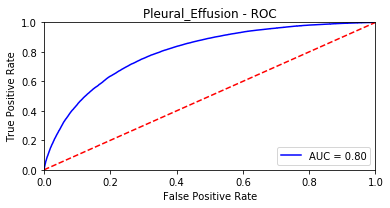

***** Precision / Recall *****


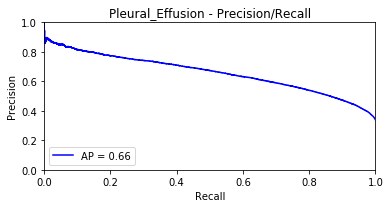


VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.753458
Hamming Loss,0.246542
Hamming Accuracy,0.753458
Combined Recall,0.832552
Combined Precision,0.800572
Combined F1,0.816249


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Pleural_Effusion,9106,8407,0.832552,0.800572,0.816249,0.809019,0.674797


***** ROC *****


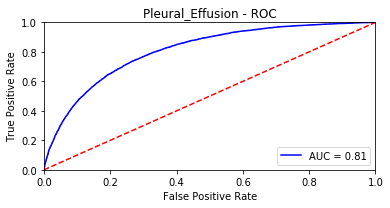

***** Precision / Recall *****


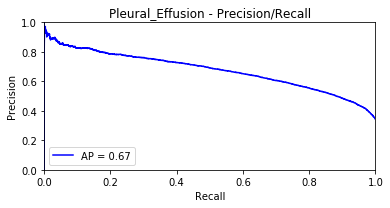

In [10]:
metrics = StandardTraining.loadMetrics(path) 
metrics.displayMetrics()

#### As you can see, the Recall after the 2 epochs was 96.6% with a Precision of 82%.  The AUC was 81%.
These are pretty good numbers if Recall is the primary goal.  If all we were interested in was predicting Pleural Effusions, we would take this as a very good starting point and concentrate our hyperparameter tuning here.

If we look at the F1 and F2 score, we get 81.3% and 86.5% respectively.  F2 is the weighted harmonic mean giving bias to the Recall score.  Weight Recall with 2 and Weight Precision with 1 (F1 weighs both as 1):

$\frac{2+1}{\frac{2}{0.965862} + \frac{1}{0.71654}} = 0.86548$

## Let's look at DenseNet and the Custom model to see how they compare:

*Note: Both the Custom and DenseNet models run images at 224x244 due to memory constraints.  The ResNet runs at the default image size of 320x320.*

## Custom

<a href="notebooks/ModelRuns/CustomPneumonia_Pleural_Effusion.ipynb" >CustomPneumonia_Pleural_Effusion</a>

*Note:  Model was poorly named "CustomPneumoniaNN".  Pneumonia was named when used with a Kaggle dataset, but does NOT necessarily mean the target is Pneumonia.*

In [11]:
save_name = 'CustomPneumonia_Pleural_Effusion'
path= f'notebooks/ModelRuns/saved/{save_name}/'
StandardTraining.displayRunParameters(path)
metrics = StandardTraining.loadMetrics(path) 

display_args = {'metricDataSource':MetricDataSource.ValidationOnly, 
                  'showCombinedMetrics':True, 
                  'showMetricDataFrame':False, 
                  'showROCCurves':False, 
                  'showPrecisionRecallCurves':False}

metrics.displayMetrics(**display_args)

Network Name:  CustomPneumoniaNN
Nework Arguments:  out_channels:1,image_size:(224, 224)


,Paramter,Value
0,number_images,0
1,batch_size,8
2,learning_rate,1e-05
3,num_epochs,1
4,epoch_args,standard
5,use_positivity_weights,False
6,image_width,224
7,image_height,224
8,affineDegrees,5
9,translatePrecent,0.05


Targets:  Pleural_Effusion

VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.733027
Hamming Loss,0.266973
Hamming Accuracy,0.733027
Combined Recall,0.861472
Combined Precision,0.764220
Combined F1,0.809937


## DenseNet_Pleural_Effusion

<a href="notebooks/ModelRuns/DenseNet_Pleural_Effusion.ipynb" >DenseNet_Pleural_Effusion</a>

The saved folder for this notebook was lost, but you can see the results directly in the notebook above.

Both the Custom and DenseNet produced similar values for Recall, around the 85% range.  These lower values could just be a "Stochastic volatility" issue since the train/validation split is randomly done with each run.  It could also be that the reduced image size has an influence.  

But with this and other runs along with the increased time and resources needed for DenseNet and the Custom models, ResNet was mostly used for the rest of the runs!

# 5 Targets <a class="anchor" id="5_Targets"></a>

## ResNet34_Oversample_L2_Sum_PosWeight_5_Targets

<a href="notebooks/ModelRuns/ResNet34_Oversample_L2_Sum_PosWeight_5_Targets.ipynb" >ResNet34_Oversample_L2_Sum_PosWeight_5_Targets</a>

#### Targets:
- Atelectasis
- Cardiomegaly
- Consolidation
- Edema
- Pleural Effusion

This run is similar to the Pleural Effusion run from above, but now with 5 targets.  The 5 targets were chosen from the CheXpert competition list of targets.

This run has most of the training featured implemented (see run parameters below):

Network Name:  ResNet_GrayScale
Nework Arguments:  layers:34,drop_out_precent:0.5,out_channels:5


,Paramter,Value
0,number_images,0
1,batch_size,64
2,learning_rate,1e-05
3,num_epochs,4
4,epoch_args,standard
5,use_positivity_weights,True
6,image_width,320
7,image_height,320
8,affineDegrees,5
9,translatePrecent,0.05


Targets:  Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion

TRAINING

▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.208979
Hamming Loss,0.364463
Hamming Accuracy,0.635537
Combined Recall,0.304625
Combined Precision,0.172284
Combined F1,0.206766


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Atelectasis,17402,24427,0.242328,0.172637,0.201630,0.522524,0.171640
1,Cardiomegaly,12805,67105,0.865834,0.165219,0.277487,0.707593,0.228392
2,Consolidation,7637,43540,0.705382,0.123725,0.210524,0.720979,0.186566
3,Edema,25177,18418,0.187354,0.256108,0.216401,0.582845,0.265360
4,Pleural_Effusion,36519,47585,0.760207,0.583419,0.660183,0.810004,0.672999


***** ROC *****


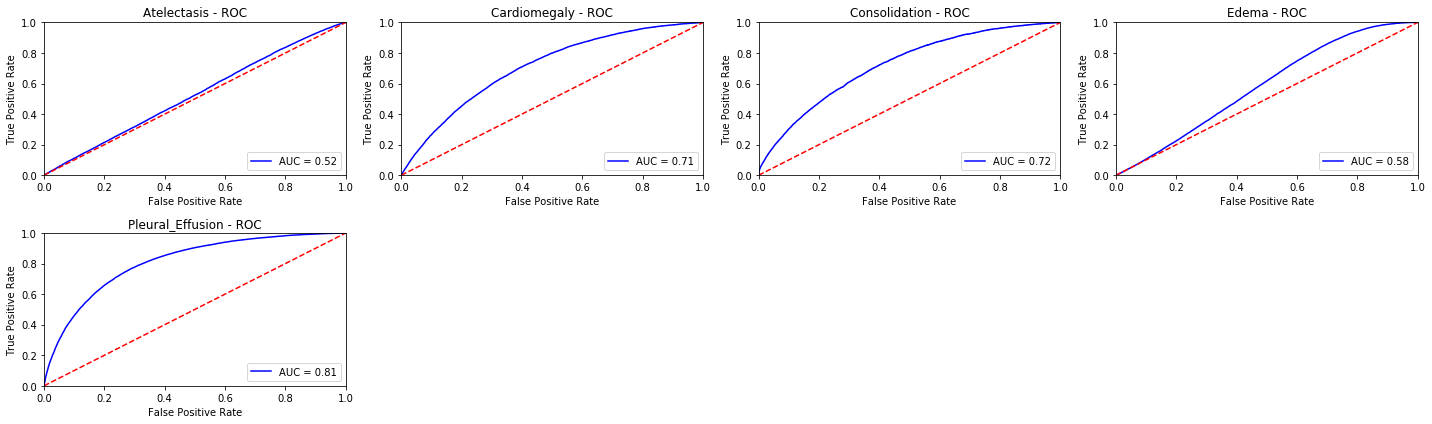

***** Precision / Recall *****


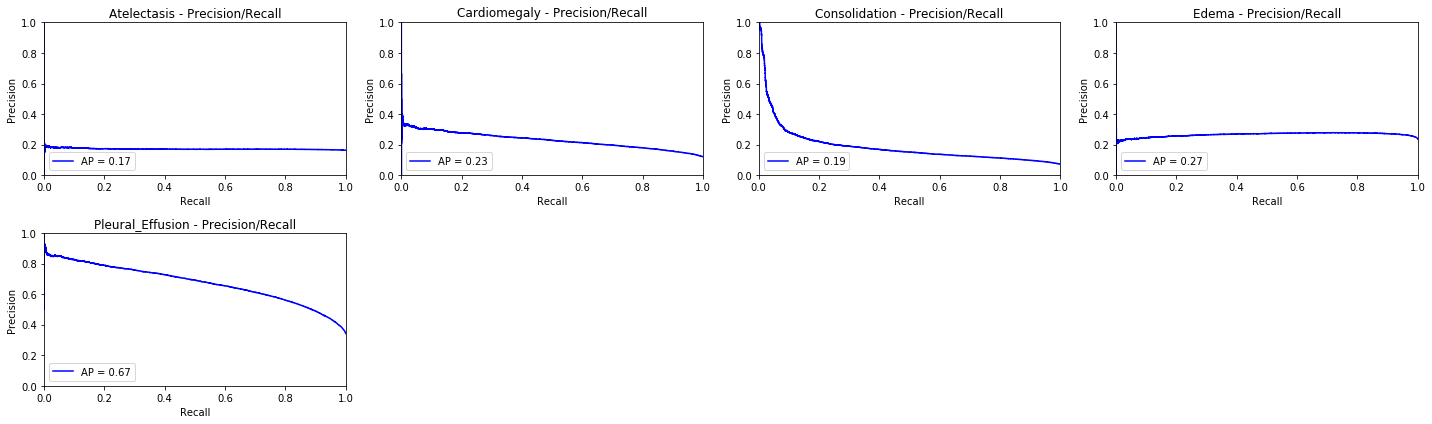


VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.169521
Hamming Loss,0.426366
Hamming Accuracy,0.573634
Combined Recall,0.355300
Combined Precision,0.169241
Combined F1,0.217143


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Atelectasis,4121,5562,0.202863,0.150306,0.172674,0.508370,0.153481
1,Cardiomegaly,3019,17700,0.875124,0.149266,0.255032,0.686749,0.199851
2,Consolidation,1571,14899,0.813495,0.085778,0.155191,0.678652,0.101998
3,Edema,6109,8691,0.363398,0.255437,0.300000,0.585033,0.255967
4,Pleural_Effusion,8866,15329,0.875592,0.506426,0.641703,0.818579,0.686954


***** ROC *****


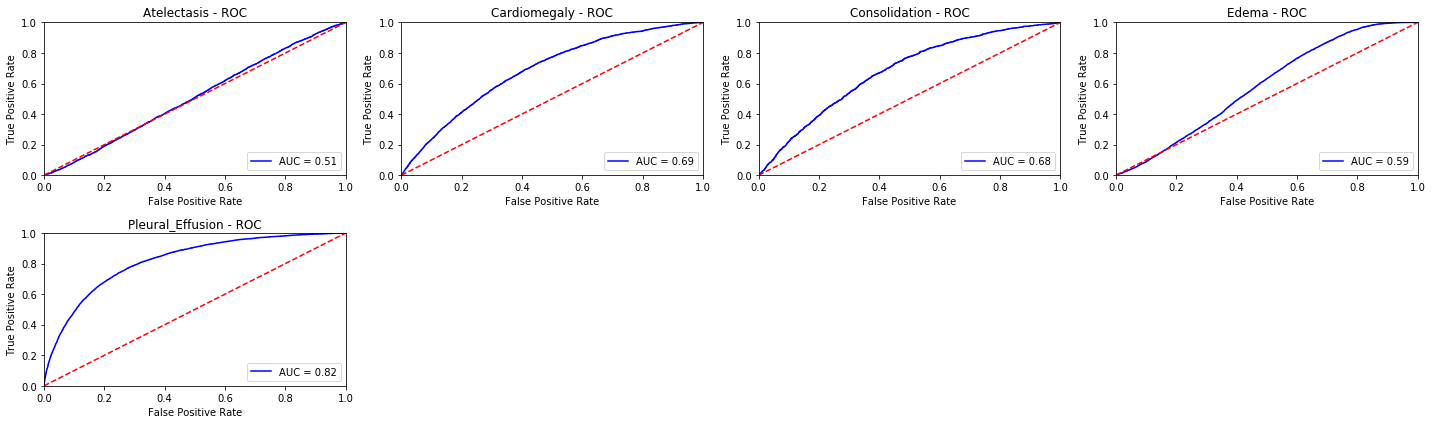

***** Precision / Recall *****


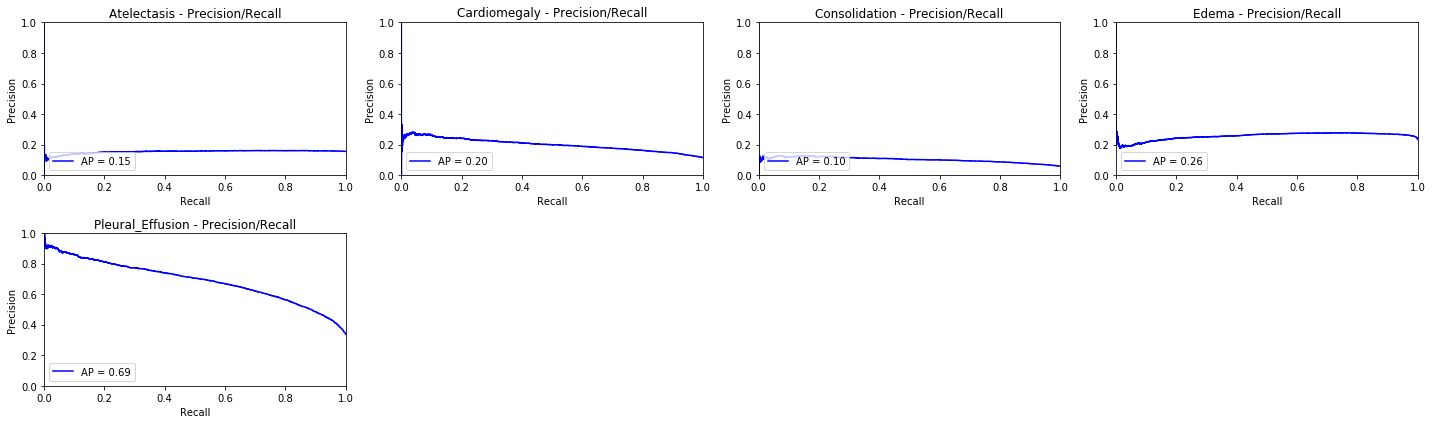


ACCURACY

▔▔▔▔


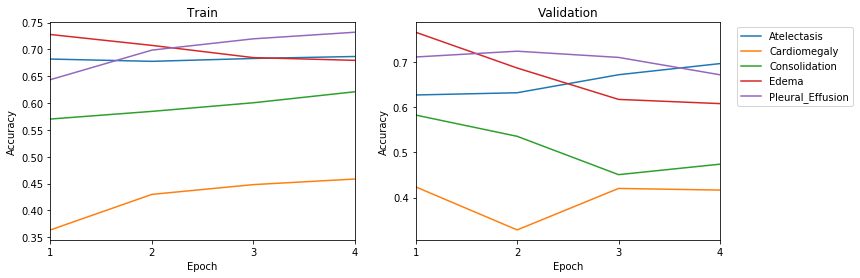


RECALL

▔▔▔


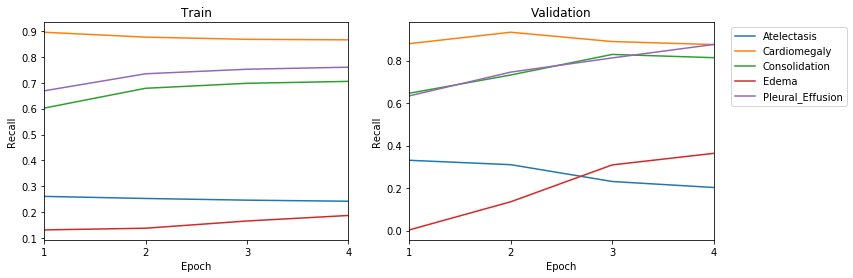


PRECISION

▔▔▔▔▔▔


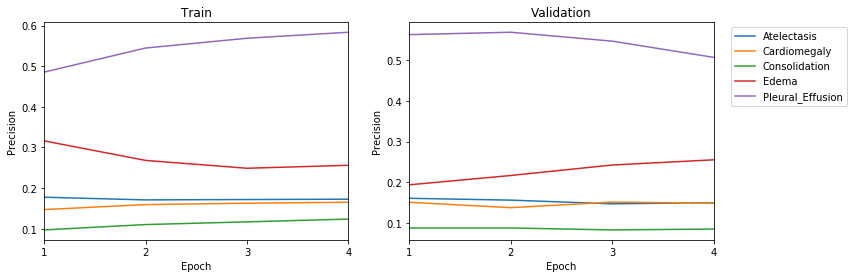


F1

▔


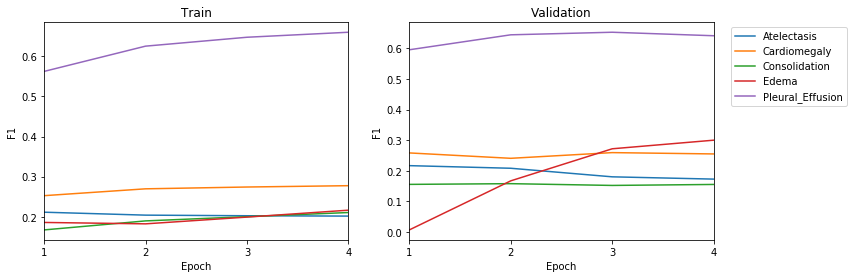


ROC AUC

▔▔▔▔


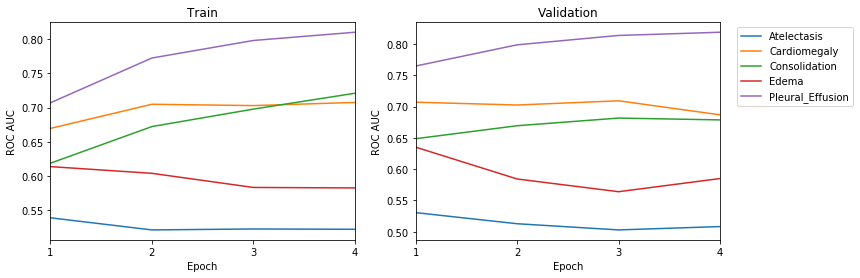


AVERAGE PRECISION

▔▔▔▔▔▔▔▔


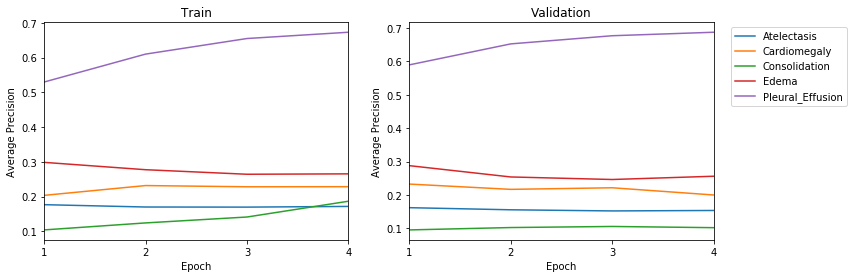

In [12]:
save_name = 'ResNet34_Oversample_L2_Sum_PosWeight_5_Targets'
path= f'notebooks/ModelRuns/saved/{save_name}/'
StandardTraining.displayRunParameters(path)
metrics = StandardTraining.loadMetrics(path) 

metrics.displayMetrics()
metrics.displayEpochProgression()

### As you can, the numbers were not very good

Only 3 of the 5 targets had some progress in training.  The other 2 targets (Atelectasis,Edema) did not do much better than 50/50 chance.  You can also see from the epoch progression, neither train of val was able to increase feature performance with more epoch (with the exception of Pleural Effusion).

# All 12 Targets <a class="anchor" id="All_12_Targets"></a>

Network Name:  ResNet_GrayScale
Nework Arguments:  layers:34,drop_out_precent:0.5,out_channels:12


,Paramter,Value
0,number_images,0
1,batch_size,64
2,learning_rate,1e-05
3,num_epochs,2
4,epoch_args,standard
5,use_positivity_weights,True
6,image_width,320
7,image_height,320
8,affineDegrees,5
9,translatePrecent,0.05


Targets:  

TRAINING

▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.070698
Hamming Loss,0.256169
Hamming Accuracy,0.743831
Combined Recall,0.559423
Combined Precision,0.391042
Combined F1,0.431125


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,28389,50925,0.684807,0.381757,0.490229,0.823958,0.635104
1,Cardiomegaly,39628,62113,0.728147,0.464557,0.567225,0.830272,0.654103
2,Lung_Opacity,88448,93903,0.609183,0.573794,0.590959,0.626146,0.597991
3,Lung_Lesion,27198,49051,0.726487,0.402826,0.518276,0.855167,0.671039
4,Edema,49114,76852,0.758725,0.484880,0.591652,0.806052,0.597335
5,Consolidation,31121,54526,0.692555,0.395279,0.503298,0.818559,0.628081
6,Pneumonia,19396,42130,0.755517,0.347828,0.476351,0.879258,0.667951
7,Atelectasis,43380,76874,0.622430,0.351237,0.449066,0.694126,0.478691
8,Pneumothorax,28357,56417,0.712699,0.358225,0.476797,0.824873,0.606382
9,Pleural_Effusion,71673,85548,0.678414,0.568383,0.618543,0.735183,0.636767


***** ROC *****


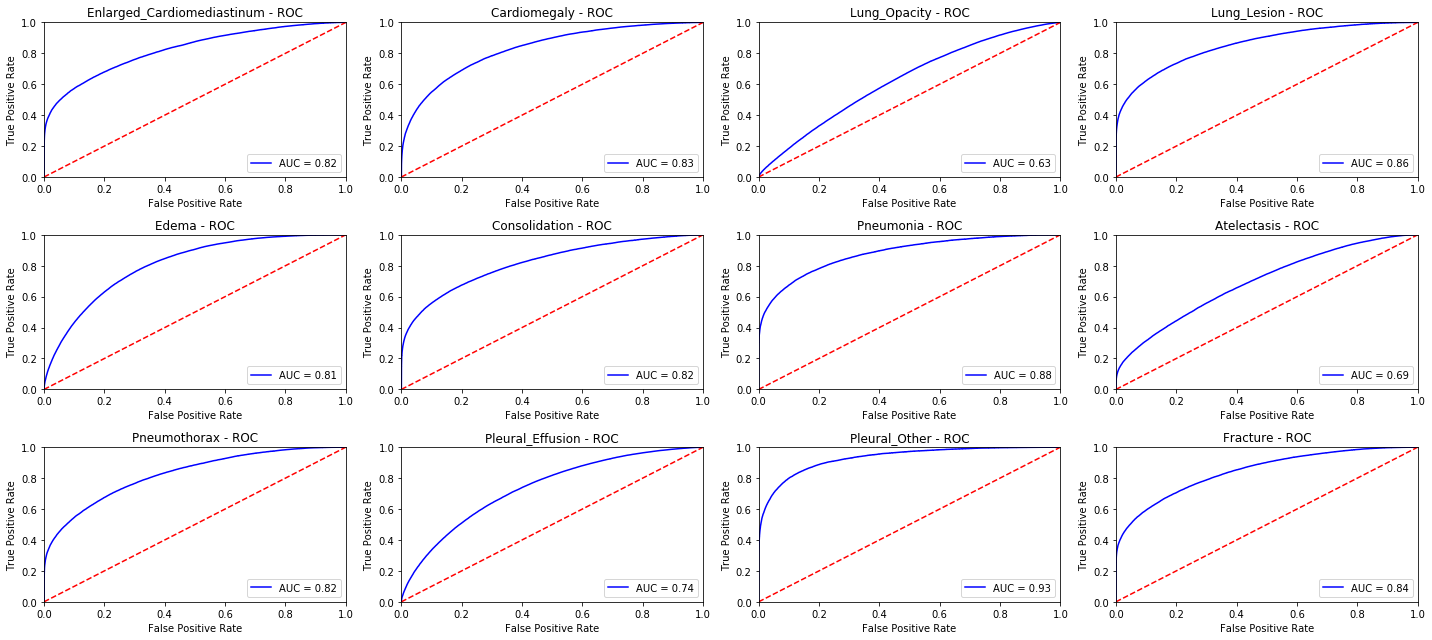

***** Precision / Recall *****


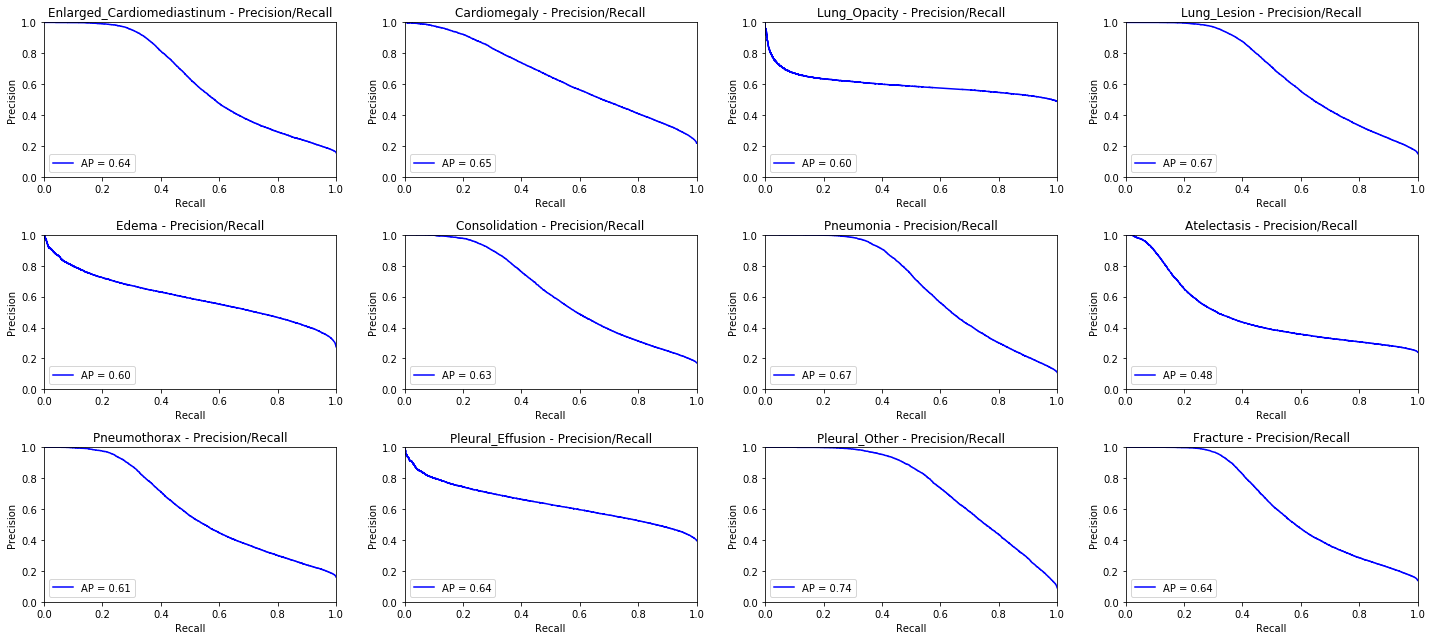


VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.073240
Hamming Loss,0.210583
Hamming Accuracy,0.789417
Combined Recall,0.436456
Combined Precision,0.263757
Combined F1,0.305644


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,1360,715,0.069853,0.132867,0.091566,0.578662,0.076578
1,Cardiomegaly,2968,3437,0.375674,0.324411,0.348165,0.756275,0.298674
2,Lung_Opacity,12046,14266,0.670430,0.566101,0.613864,0.663134,0.584248
3,Lung_Lesion,1145,2020,0.149345,0.084653,0.108057,0.637403,0.069609
4,Edema,6166,13171,0.802952,0.375902,0.512075,0.768149,0.471081
5,Consolidation,1589,3638,0.234739,0.102529,0.142720,0.621928,0.092922
6,Pneumonia,728,3257,0.214286,0.047897,0.078294,0.597343,0.040977
7,Atelectasis,4168,8483,0.410029,0.201462,0.270176,0.594270,0.196096
8,Pneumothorax,2167,5071,0.371943,0.158943,0.222713,0.656757,0.152650
9,Pleural_Effusion,9032,12275,0.723428,0.532301,0.613320,0.760042,0.587754


***** ROC *****


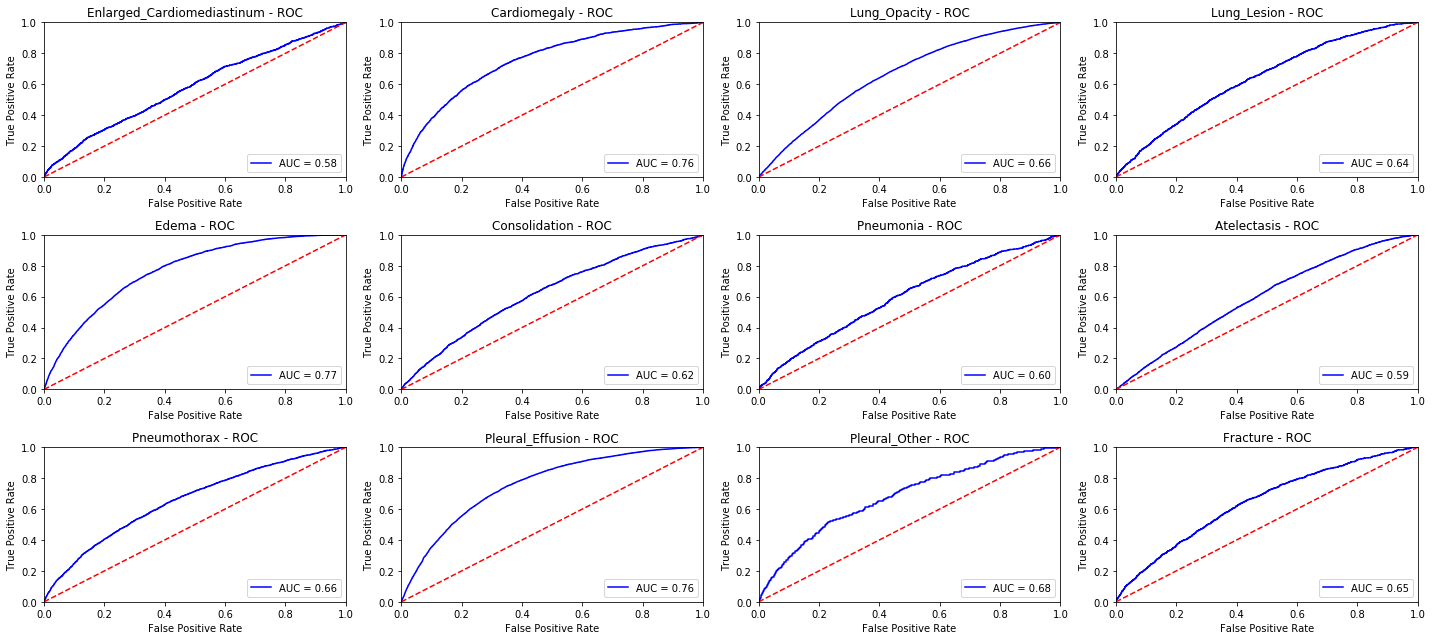

***** Precision / Recall *****


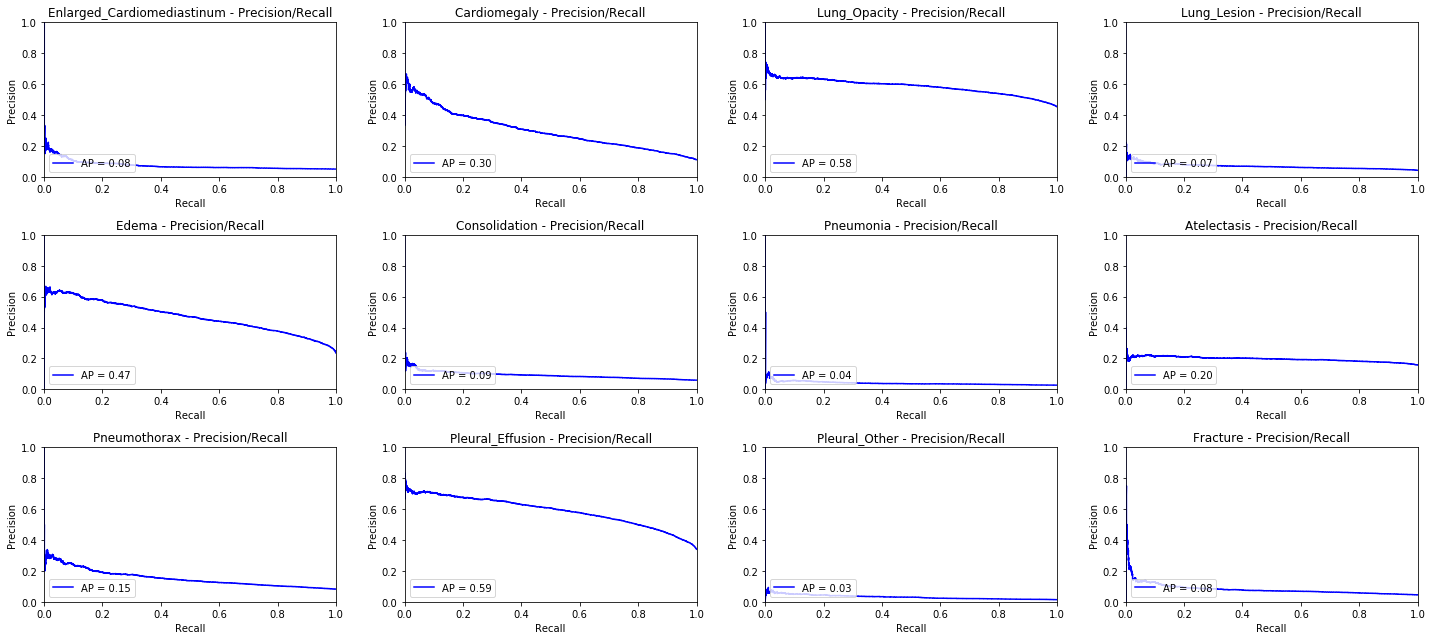


ACCURACY

▔▔▔▔


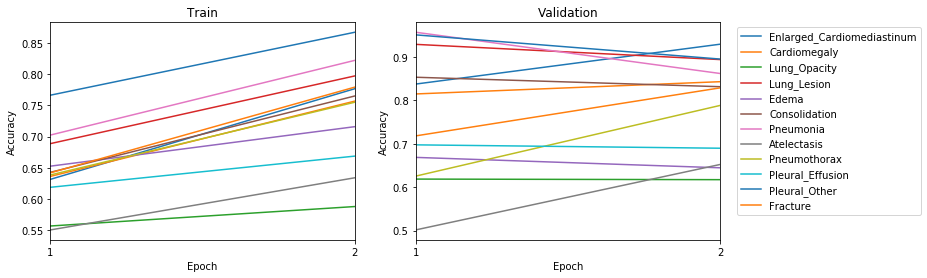


RECALL

▔▔▔


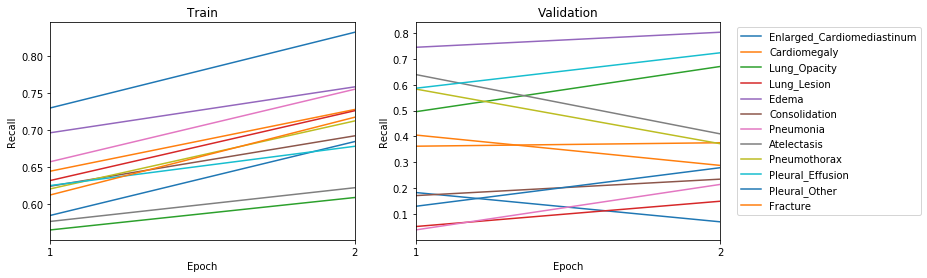


PRECISION

▔▔▔▔▔▔


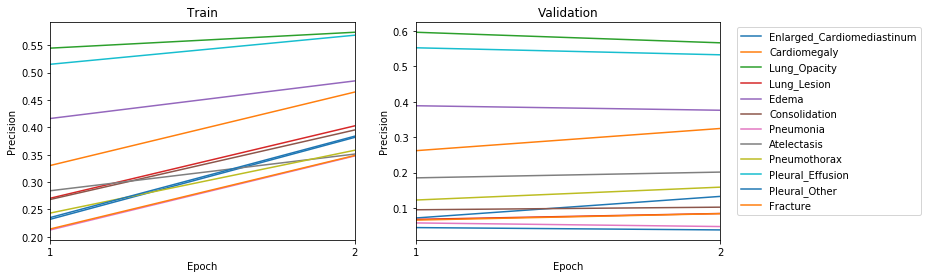


F1

▔


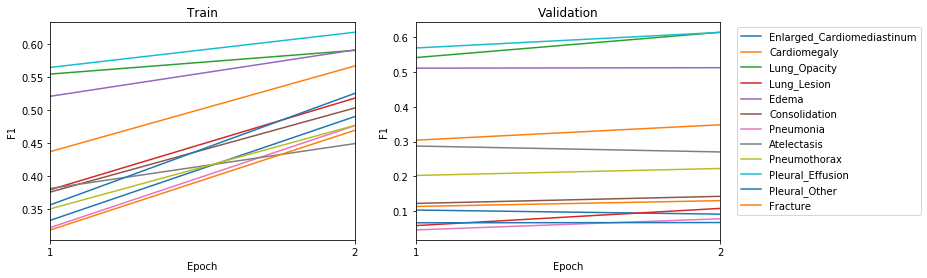


ROC AUC

▔▔▔▔


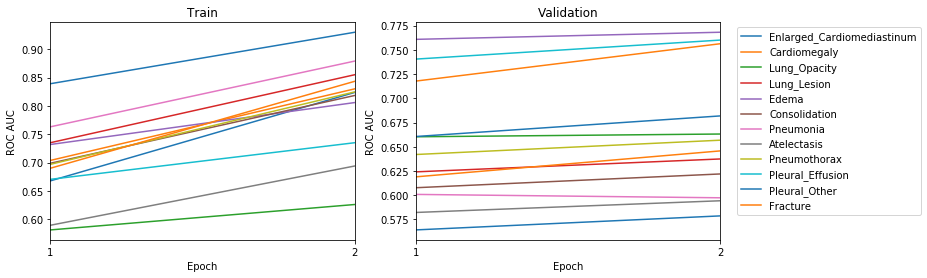


AVERAGE PRECISION

▔▔▔▔▔▔▔▔


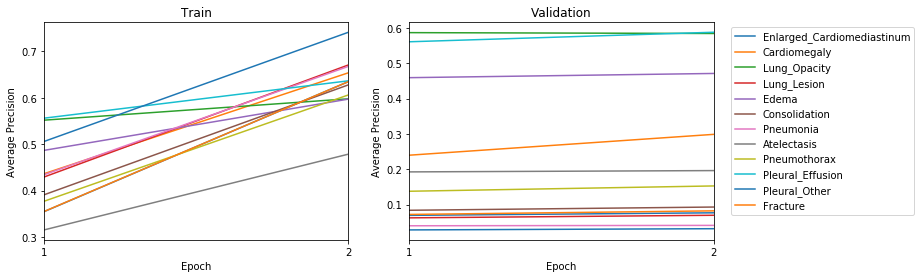

In [13]:
save_name = 'ResNet34_Oversample_L2_Sum_PosWeight_12_Targets'
path= f'notebooks/ModelRuns/saved/{save_name}/'
StandardTraining.displayRunParameters(path)
metrics = StandardTraining.loadMetrics(path) 

metrics.displayMetrics()
metrics.displayEpochProgression()

### Pretrained ResNet

Network Name:  ResNet_PreTrained
Nework Arguments:  layers:34,drop_out_precent:0.5,out_channels:12


,Paramter,Value
0,number_images,0
1,batch_size,64
2,learning_rate,1e-05
3,num_epochs,2
4,epoch_args,standard
5,use_positivity_weights,True
6,image_width,224
7,image_height,224
8,affineDegrees,5
9,translatePrecent,0.05


Targets:  

TRAINING

▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.255856
Hamming Loss,0.154669
Hamming Accuracy,0.845331
Combined Recall,0.634481
Combined Precision,0.523190
Combined F1,0.549183


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,27792,40897,0.814047,0.553195,0.658737,0.921149,0.819371
1,Cardiomegaly,38874,51297,0.819108,0.620738,0.706258,0.920638,0.825041
2,Lung_Opacity,87780,89895,0.690203,0.673964,0.681987,0.766230,0.760296
3,Lung_Lesion,27539,37874,0.842224,0.612399,0.709156,0.941498,0.859813
4,Edema,49042,68855,0.813058,0.579101,0.676421,0.882525,0.750748
5,Consolidation,30989,43864,0.805802,0.569282,0.667201,0.919201,0.822073
6,Pneumonia,18842,29252,0.870608,0.560782,0.682164,0.955870,0.869501
7,Atelectasis,42634,63096,0.727870,0.491822,0.587005,0.842196,0.712100
8,Pneumothorax,28353,43242,0.831235,0.545026,0.658370,0.928227,0.808028
9,Pleural_Effusion,71427,79216,0.793887,0.715828,0.752839,0.879275,0.834793


***** ROC *****


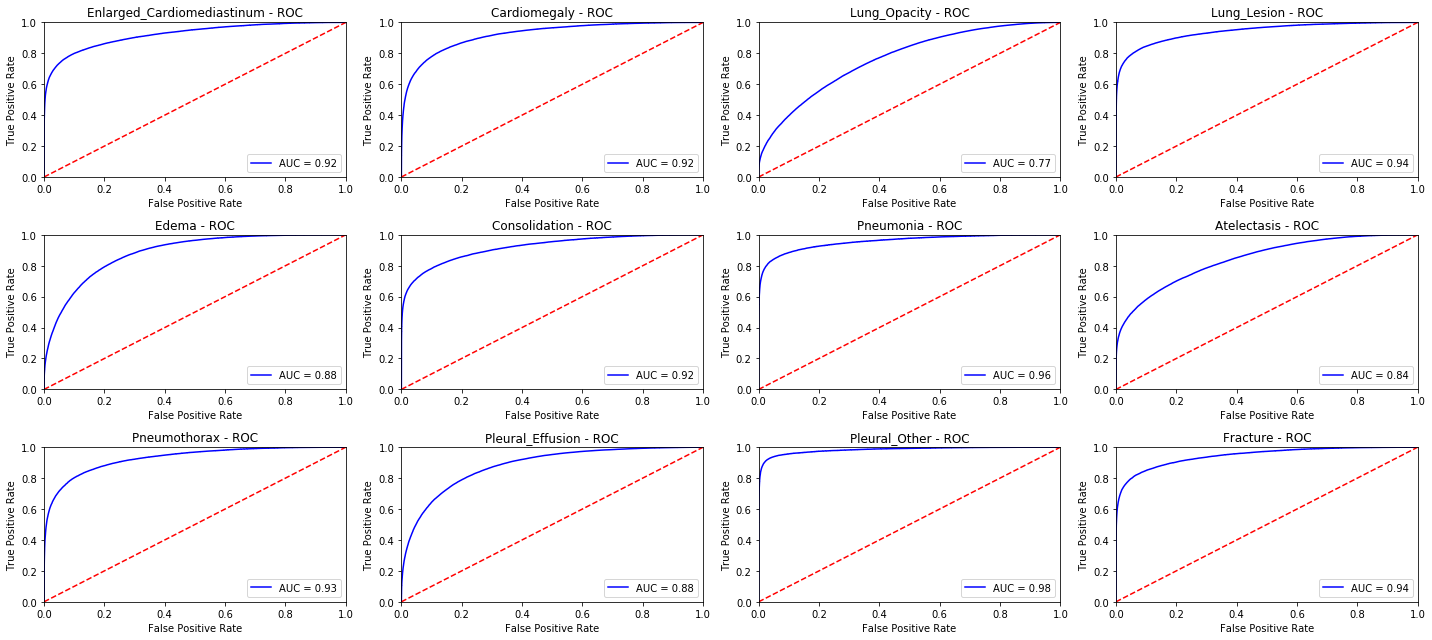

***** Precision / Recall *****


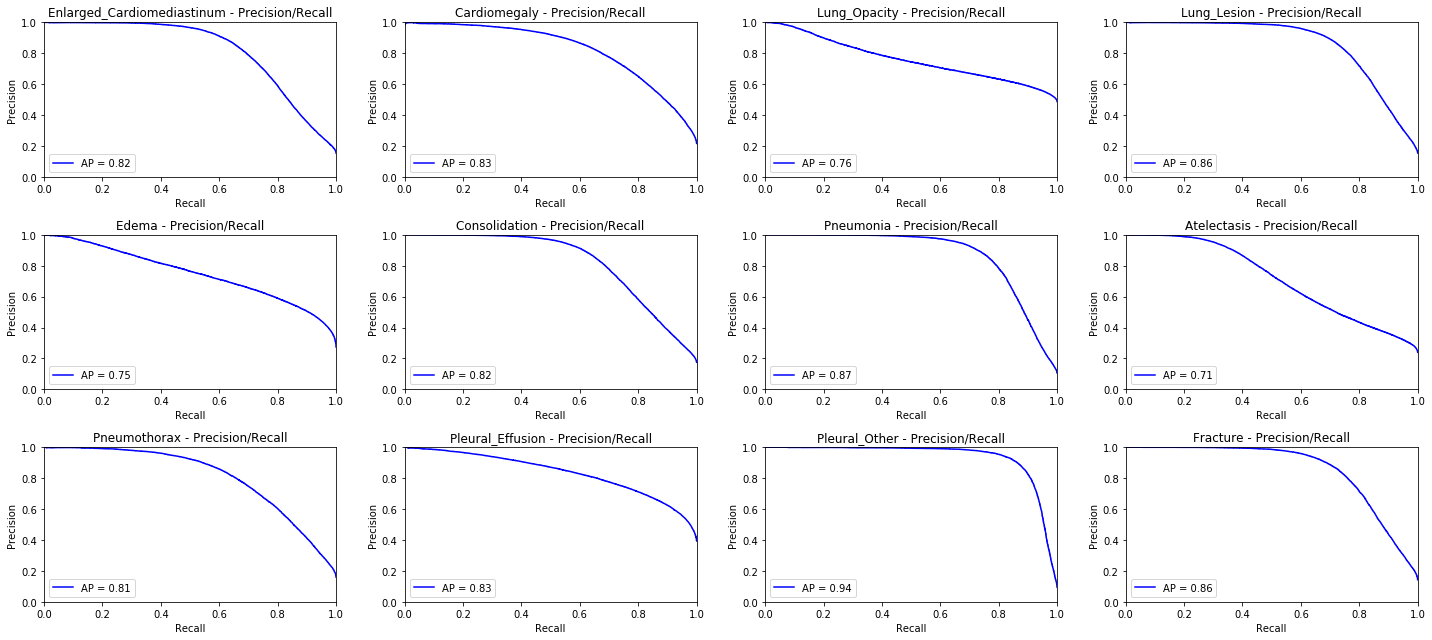


VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.109693
Hamming Loss,0.181582
Hamming Accuracy,0.818418
Combined Recall,0.444164
Combined Precision,0.307509
Combined F1,0.337678


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,1364,2073,0.188416,0.123975,0.149549,0.619422,0.093925
1,Cardiomegaly,2956,4167,0.503045,0.356851,0.417521,0.797455,0.373997
2,Lung_Opacity,11989,12571,0.617066,0.588497,0.602443,0.679493,0.601616
3,Lung_Lesion,1087,2647,0.263109,0.108047,0.153187,0.680805,0.091803
4,Edema,6098,9647,0.707773,0.447393,0.548238,0.794989,0.498590
5,Consolidation,1573,3433,0.265734,0.121759,0.167000,0.662971,0.104132
6,Pneumonia,680,2221,0.238235,0.072940,0.111686,0.675856,0.061291
7,Atelectasis,4186,8653,0.468705,0.226742,0.305631,0.630723,0.224188
8,Pneumothorax,2153,4568,0.537854,0.253503,0.344592,0.783401,0.288115
9,Pleural_Effusion,8859,10972,0.745457,0.601896,0.666028,0.823539,0.694592


***** ROC *****


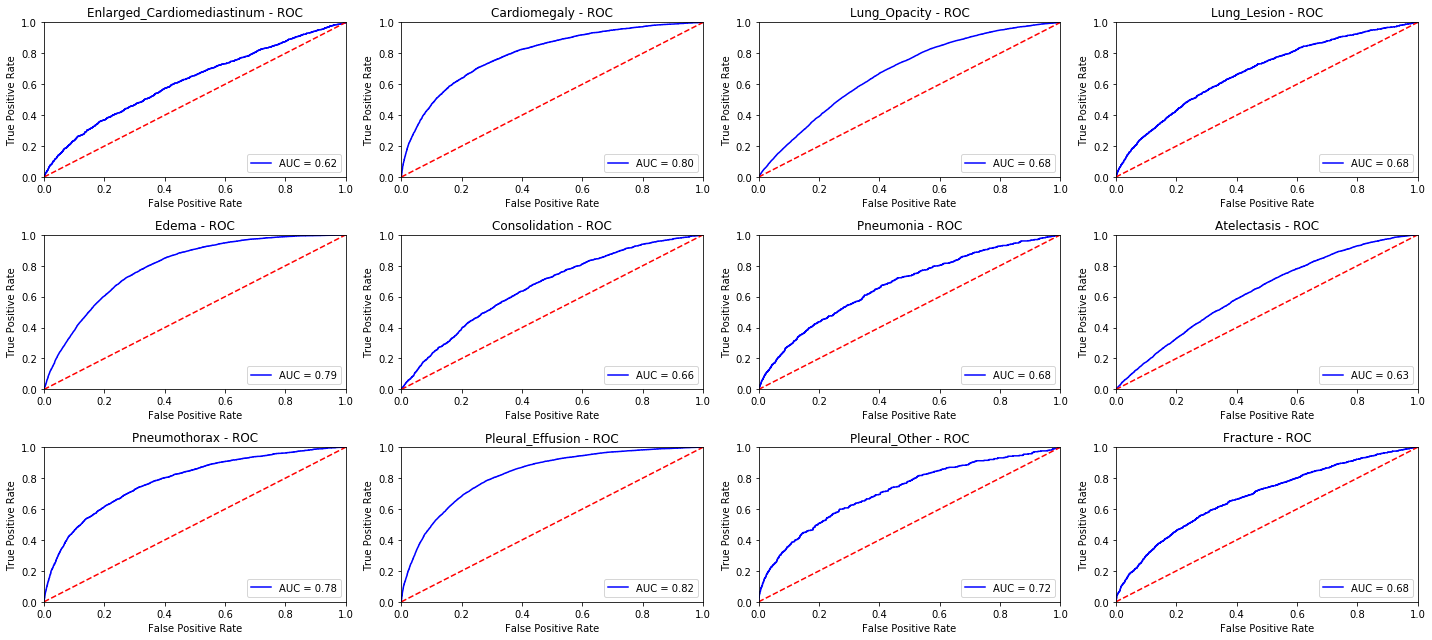

***** Precision / Recall *****


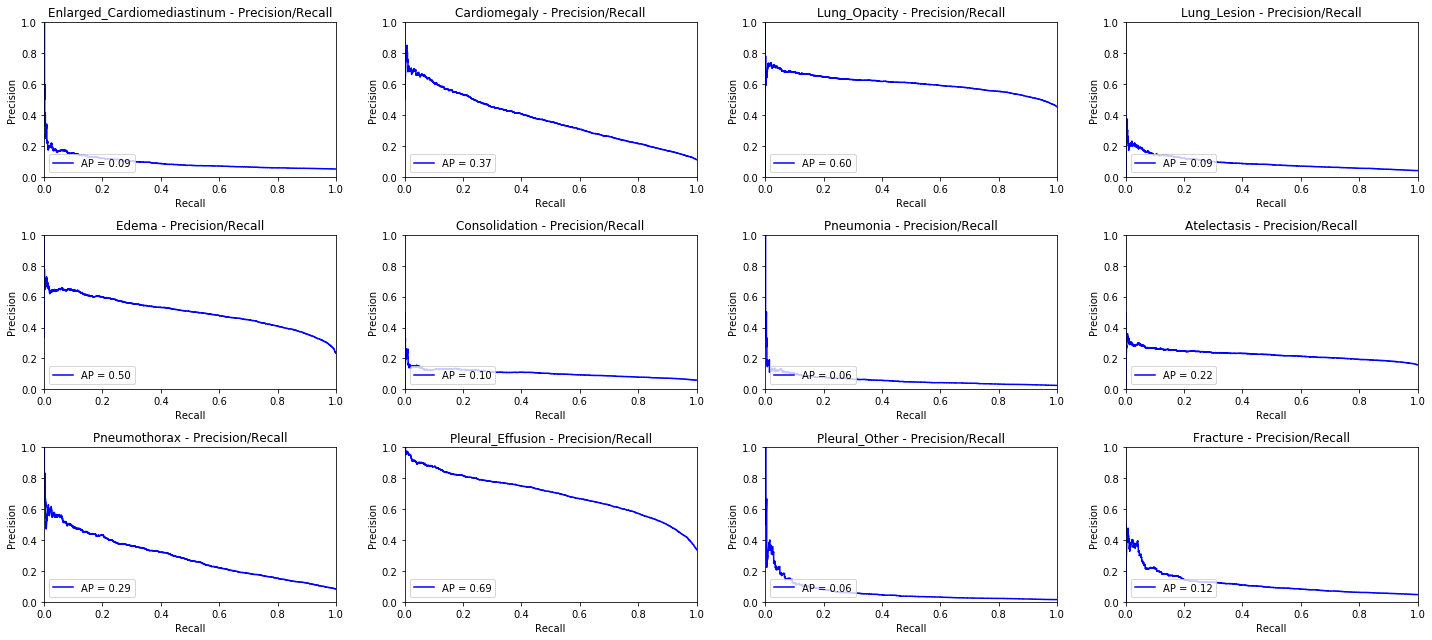


ACCURACY

▔▔▔▔


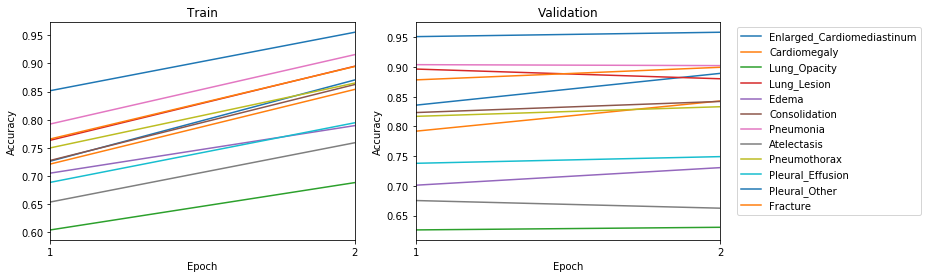


RECALL

▔▔▔


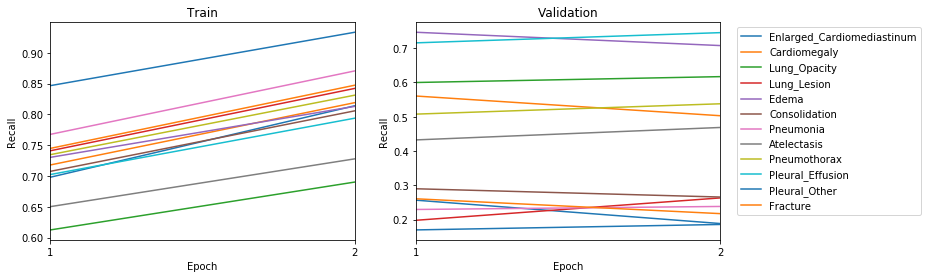


PRECISION

▔▔▔▔▔▔


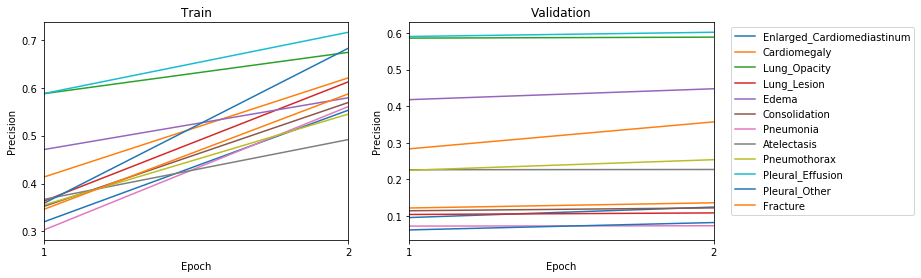


F1

▔


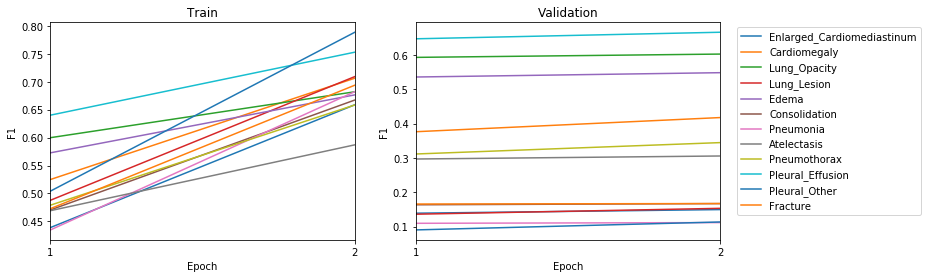


ROC AUC

▔▔▔▔


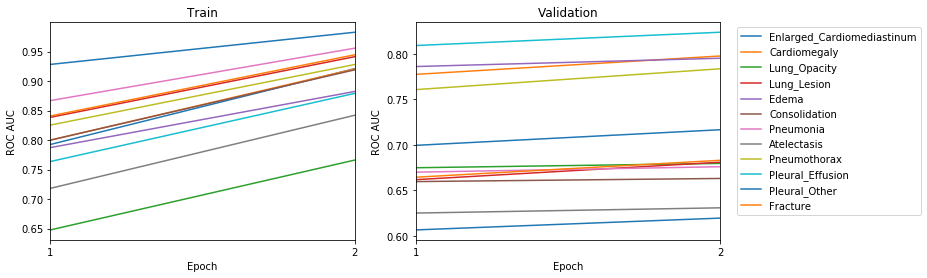


AVERAGE PRECISION

▔▔▔▔▔▔▔▔


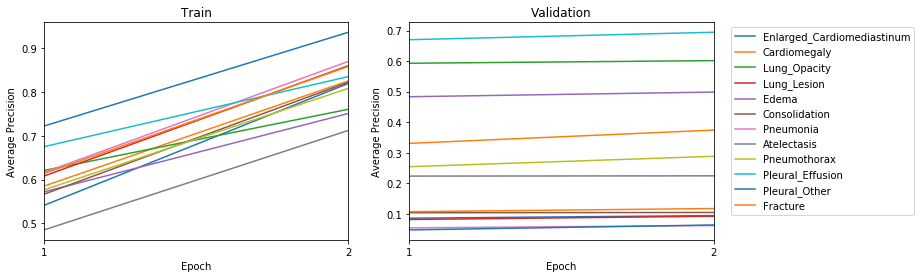

In [14]:
save_name = 'ResNet34_Pretrained_Oversample_L2_Sum_PosWeight_12_Targets'
path= f'notebooks/ModelRuns/saved/{save_name}/'
StandardTraining.displayRunParameters(path)
metrics = StandardTraining.loadMetrics(path) 

metrics.displayMetrics()
metrics.displayEpochProgression()

#### Viritually no change in the Validation Combined Recall scores

This is expected somewhat, but the duration of the training was not that much better.

# 20 Epochs <a class="anchor" id="20_Epochs"></a>

### ResNet with all 12 Targets with 20 Epochs:

<a href="notebooks/ModelRuns/ResNet34_Oversample_L2_Sum_PosWeight_12_Targets_20_Epochs.ipynb" >ResNet34_Oversample_L2_Sum_PosWeight_12_Targets_20_Epochs</a>

Network Name:  ResNet_GrayScale
Nework Arguments:  layers:34,drop_out_precent:0.5,out_channels:12


,Paramter,Value
0,number_images,25000
1,batch_size,64
2,learning_rate,1e-05
3,num_epochs,20
4,epoch_args,standard
5,use_positivity_weights,True
6,image_width,320
7,image_height,320
8,affineDegrees,5
9,translatePrecent,0.05


Targets:  

TRAINING

▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.526673
Hamming Loss,0.082643
Hamming Accuracy,0.917357
Combined Recall,0.768183
Combined Precision,0.697907
Combined F1,0.713543


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,5857,7366,0.922998,0.733913,0.817666,0.983428,0.946545
1,Cardiomegaly,8605,10575,0.915166,0.744681,0.821168,0.977287,0.934286
2,Lung_Opacity,21542,21932,0.805543,0.791218,0.798316,0.901722,0.899978
3,Lung_Lesion,5595,6987,0.927256,0.742522,0.824670,0.985741,0.949754
4,Edema,12112,15005,0.881027,0.711163,0.787034,0.953138,0.896425
5,Consolidation,7367,8809,0.919370,0.768873,0.837413,0.981663,0.948200
6,Pneumonia,4252,5535,0.943321,0.724661,0.819659,0.989571,0.953589
7,Atelectasis,10754,13321,0.849916,0.686135,0.759294,0.946634,0.888812
8,Pneumothorax,6438,8566,0.912395,0.685734,0.782991,0.978700,0.926639
9,Pleural_Effusion,17870,19020,0.863626,0.811409,0.836704,0.944557,0.926087


***** ROC *****


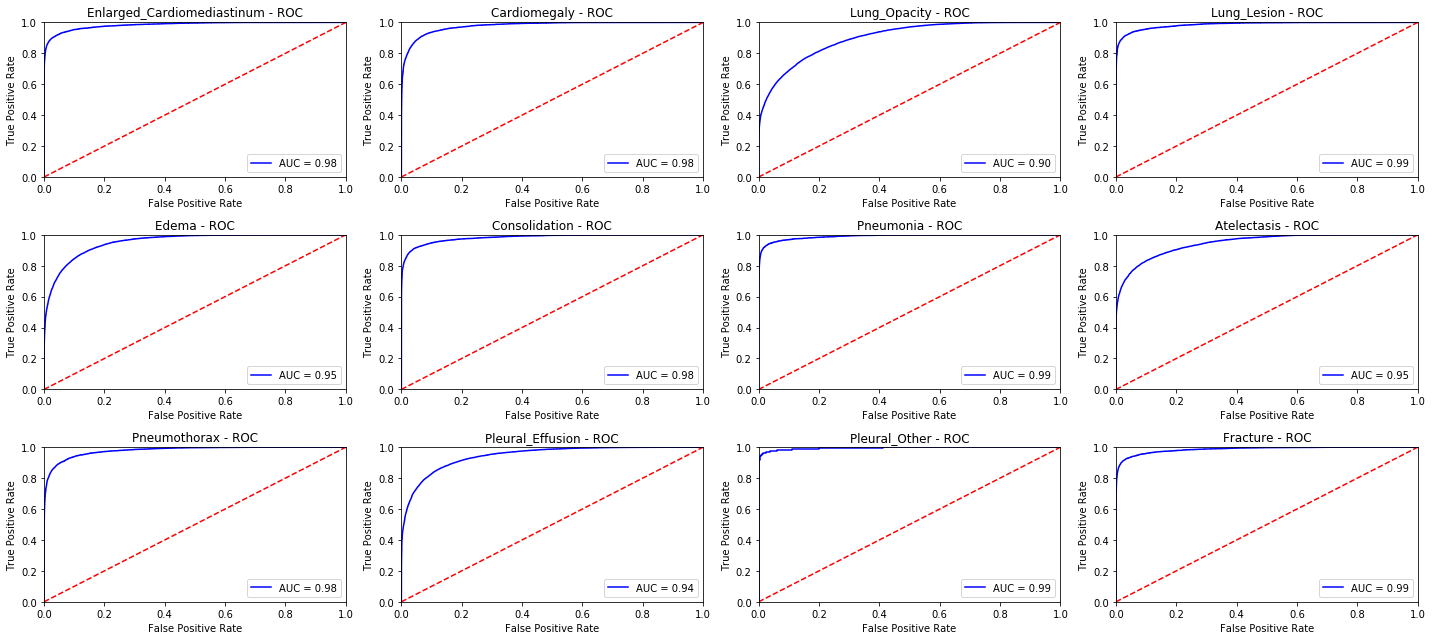

***** Precision / Recall *****


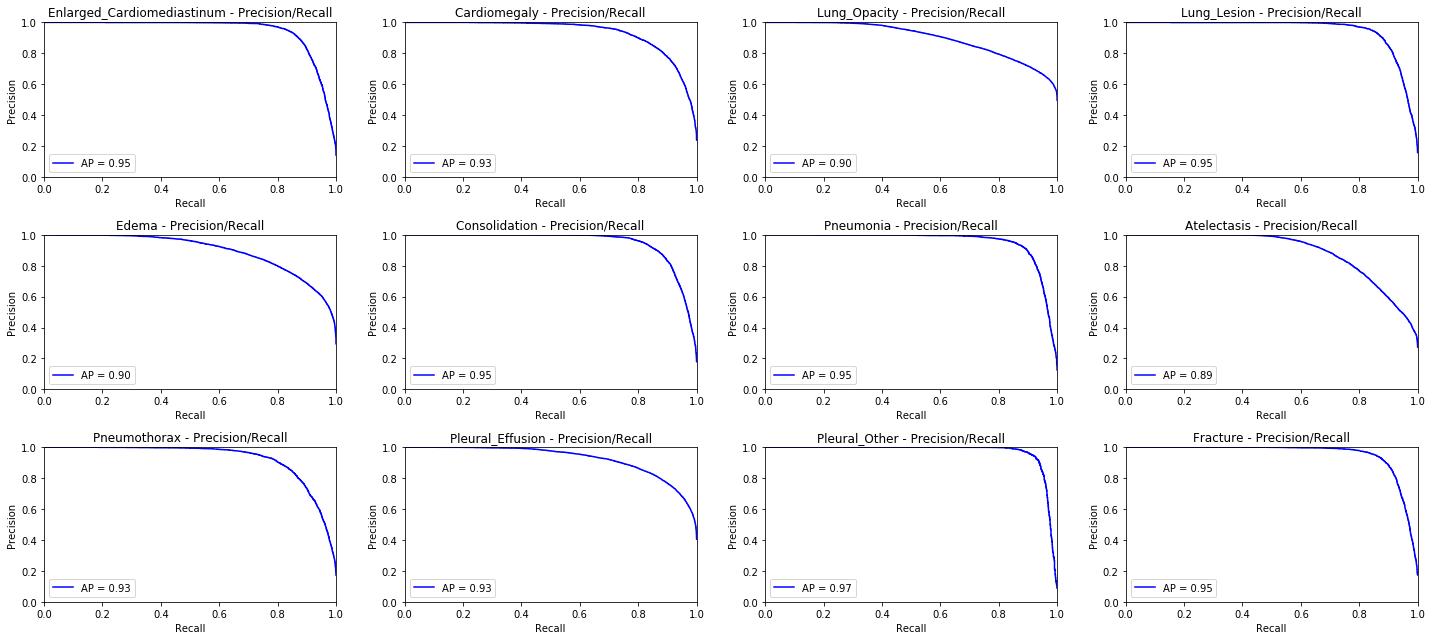


VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.073999
Hamming Loss,0.193756
Hamming Accuracy,0.806244
Combined Recall,0.415355
Combined Precision,0.305286
Combined F1,0.326690


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,282,894,0.269504,0.085011,0.129252,0.563703,0.083289
1,Cardiomegaly,580,605,0.370690,0.355372,0.362869,0.766631,0.325836
2,Lung_Opacity,2266,2688,0.642101,0.541295,0.587404,0.623695,0.562412
3,Lung_Lesion,186,129,0.069892,0.100775,0.082540,0.629615,0.063915
4,Edema,1146,1298,0.508726,0.449153,0.477087,0.756542,0.458977
5,Consolidation,297,869,0.269360,0.092060,0.137221,0.602442,0.086084
6,Pneumonia,110,99,0.036364,0.040404,0.038278,0.574177,0.032128
7,Atelectasis,772,924,0.248705,0.207792,0.226415,0.575308,0.195365
8,Pneumothorax,390,849,0.376923,0.173145,0.237288,0.693536,0.185865
9,Pleural_Effusion,1704,2910,0.822770,0.481787,0.607716,0.756839,0.618659


***** ROC *****


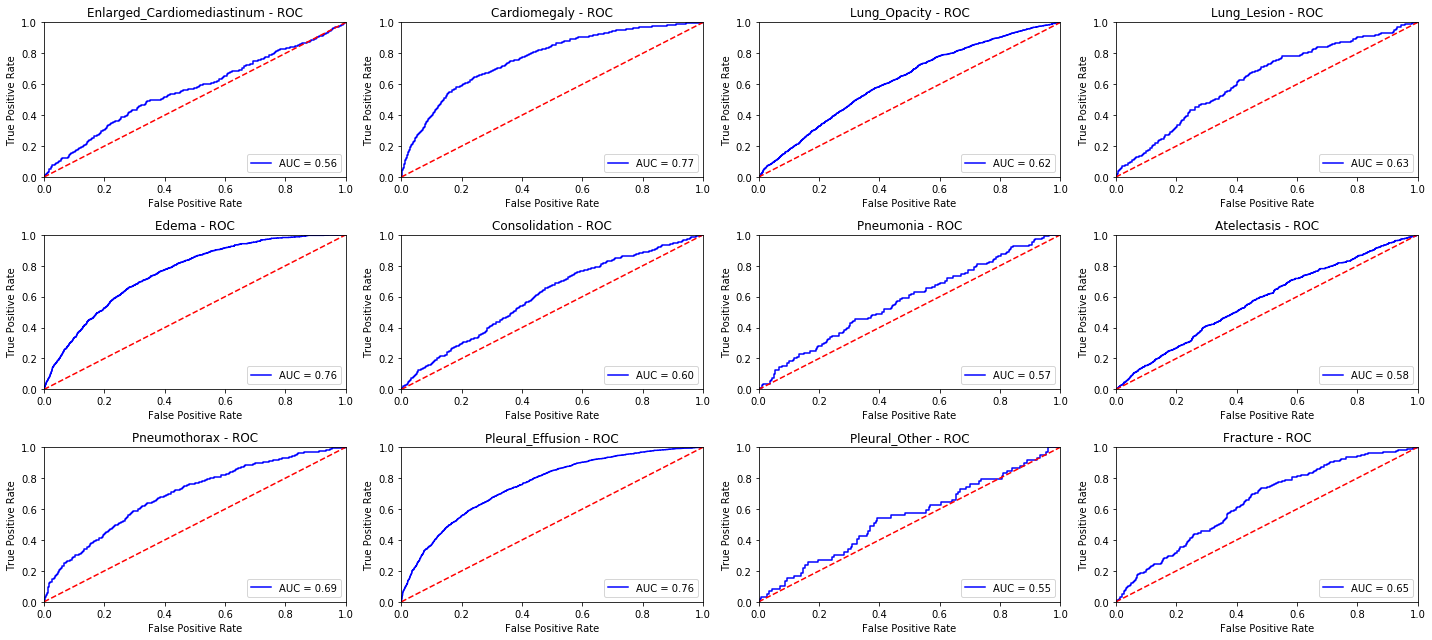

***** Precision / Recall *****


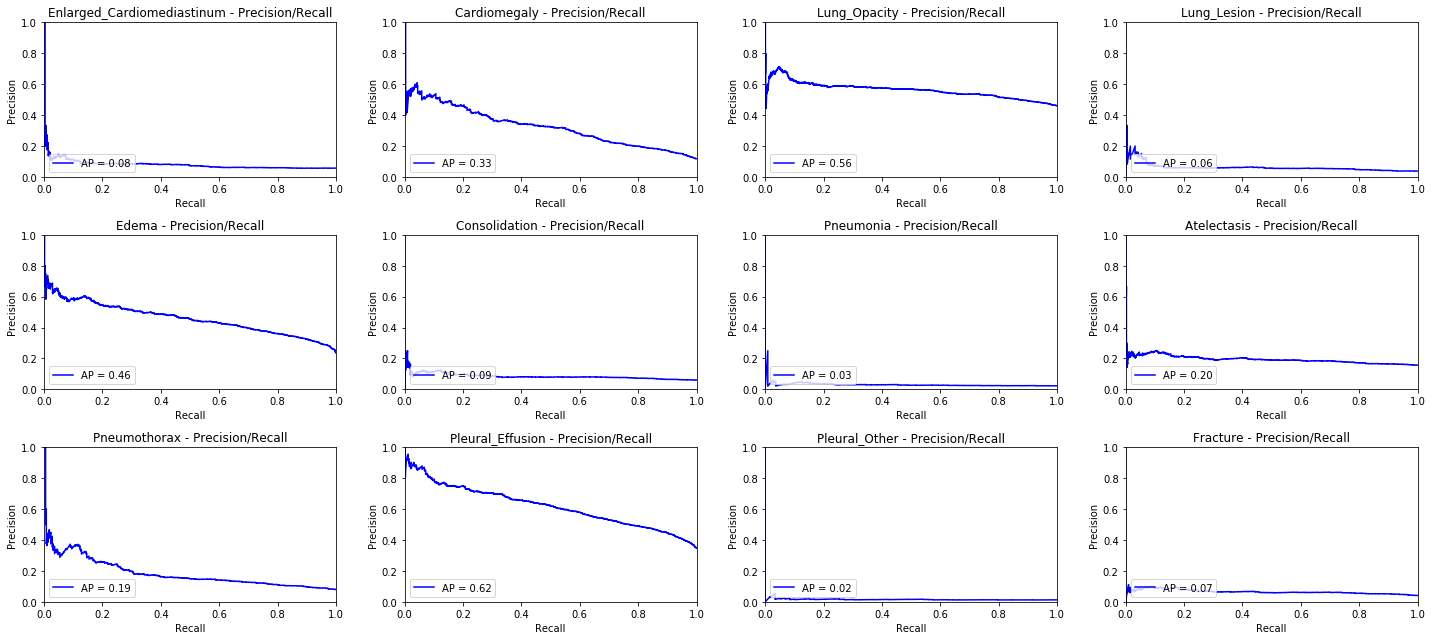


TRAIN FINAL RESULTS

▔▔▔▔▔▔▔▔


,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture
-25452.0,1,1,1,0,1,0,0,0,0,1,0,1
-25451.0,1,1,1,0,1,0,0,0,0,1,0,1
-25450.0,1,1,1,0,1,0,0,0,0,1,0,1
-25449.0,1,1,1,0,1,0,0,0,0,1,0,1
-25448.0,1,1,1,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
223392.0,0,0,0,0,0,0,0,0,0,0,0,0
223397.0,0,0,0,0,1,0,0,1,0,1,0,0
223398.0,1,0,0,0,0,0,0,0,0,0,0,0
223402.0,0,0,0,0,0,0,0,0,0,0,0,0


,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture
-25452.0,1,1,1,0,1,0,0,0,0,1,0,1
-25451.0,1,1,1,0,1,0,0,0,0,1,0,1
-25450.0,1,1,1,0,1,0,0,0,0,1,0,1
-25449.0,1,1,1,0,1,0,0,0,0,1,0,1
-25448.0,1,1,1,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
223392.0,0,0,1,0,0,0,0,0,0,0,0,0
223397.0,0,0,1,0,1,1,0,0,0,1,0,0
223398.0,1,0,1,0,1,0,0,0,0,0,0,0
223402.0,1,0,0,0,0,0,0,0,0,0,0,0


,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture
-25452.0,0.995819,0.994172,0.989521,0.000290,0.966181,0.001927,0.001891,0.055349,0.013108,0.988429,0.008873,0.995256
-25451.0,0.998661,0.943405,0.940287,0.008383,0.907845,0.001876,0.005646,0.253208,0.025222,0.957808,0.003246,0.961371
-25450.0,0.999678,0.999868,0.980721,0.000828,0.995356,0.001507,0.000106,0.008755,0.001311,0.987003,0.012743,0.999879
-25449.0,0.998583,0.999681,0.991738,0.000718,0.998302,0.000235,0.000210,0.003591,0.000878,0.981242,0.000612,0.987960
-25448.0,0.998068,0.998675,0.980885,0.004062,0.970061,0.016386,0.003336,0.028708,0.004543,0.954752,0.004928,0.951314
...,...,...,...,...,...,...,...,...,...,...,...,...
223392.0,0.059551,0.003064,0.506585,0.179777,0.317946,0.002346,0.012338,0.480597,0.329967,0.011184,0.009112,0.039235
223397.0,0.003435,0.010089,0.834416,0.059518,0.881831,0.935206,0.398462,0.096688,0.096298,0.990317,0.014695,0.026965
223398.0,0.962806,0.070954,0.527956,0.033919,0.731061,0.054588,0.029095,0.072808,0.025582,0.106971,0.005548,0.293207
223402.0,0.514735,0.080669,0.330852,0.015251,0.084944,0.014819,0.005834,0.279141,0.214357,0.323485,0.104615,0.148298



VALIDATION FINAL RESULTS

▔▔▔▔▔▔▔▔


,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture
ImageID,,,,,,,,,,,,
54,0,1,1,1,0,0,0,1,1,1,0,0
56,0,0,1,1,0,0,0,0,0,0,0,0
154,0,1,1,0,0,0,0,0,0,1,0,0
180,0,0,1,0,0,0,0,0,1,1,0,0
187,0,1,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
223276,0,1,0,0,0,0,0,0,0,0,0,0
223286,0,0,1,0,0,0,0,0,0,0,0,0
223290,0,0,1,0,0,0,0,0,0,0,0,0


,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture
54,0,0,1,0,0,1,0,0,0,1,0,0
56,0,0,0,0,0,0,0,1,0,1,0,1
154,1,1,1,0,0,1,0,1,0,1,0,0
180,0,0,1,0,0,0,0,1,0,1,0,0
187,0,1,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
223276,0,1,1,0,1,1,0,0,0,1,0,0
223286,0,0,0,0,0,0,0,1,1,1,0,0
223290,0,0,1,0,0,0,0,0,1,0,0,0
223330,0,0,0,0,1,0,0,0,0,1,0,0


,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture
54,0.077334,0.001095,0.678250,0.066726,0.071929,0.544675,0.003443,0.046549,0.056782,0.737925,0.002823,0.039650
56,0.008291,0.008855,0.133172,0.003383,0.135987,0.004597,0.005927,0.742555,0.283151,0.764283,0.001360,0.954860
154,0.620852,0.711241,0.768301,0.017725,0.478895,0.773944,0.022510,0.640573,0.095534,0.890298,0.112709,0.118202
180,0.042131,0.027220,0.683734,0.024483,0.296345,0.068229,0.006403,0.655291,0.117992,0.775105,0.081394,0.021452
187,0.018363,0.546318,0.156341,0.024508,0.277794,0.310554,0.003230,0.260627,0.050760,0.533782,0.142138,0.742498
...,...,...,...,...,...,...,...,...,...,...,...,...
223276,0.426581,0.787512,0.553473,0.075725,0.781964,0.574289,0.004426,0.150648,0.065995,0.894799,0.025939,0.016615
223286,0.046240,0.005990,0.497309,0.040975,0.013985,0.125687,0.008730,0.956722,0.744031,0.838208,0.001618,0.009000
223290,0.008460,0.000545,0.620019,0.392250,0.077927,0.069077,0.002956,0.109105,0.952156,0.126582,0.017344,0.078954
223330,0.002421,0.102332,0.460809,0.000138,0.750861,0.130960,0.003778,0.325830,0.302825,0.604168,0.000074,0.013888



ACCURACY

▔▔▔▔


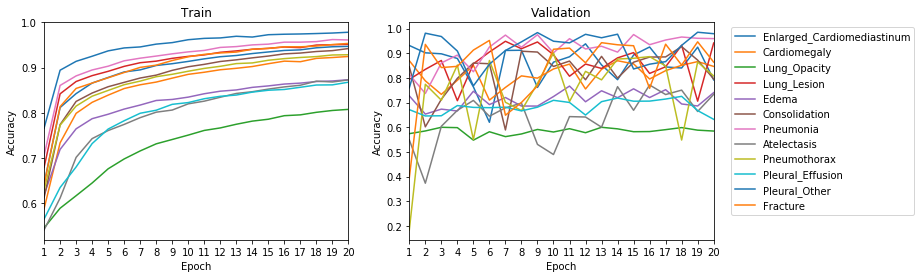


RECALL

▔▔▔


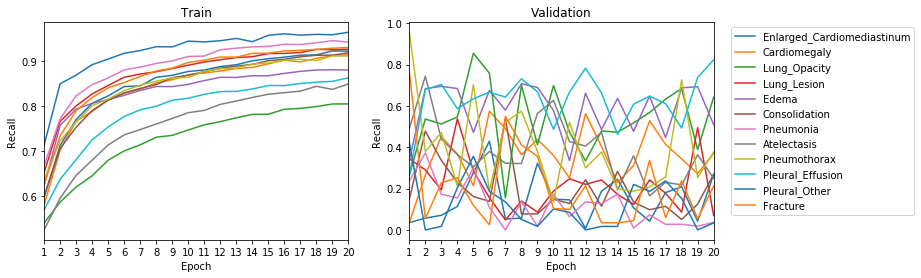


PRECISION

▔▔▔▔▔▔


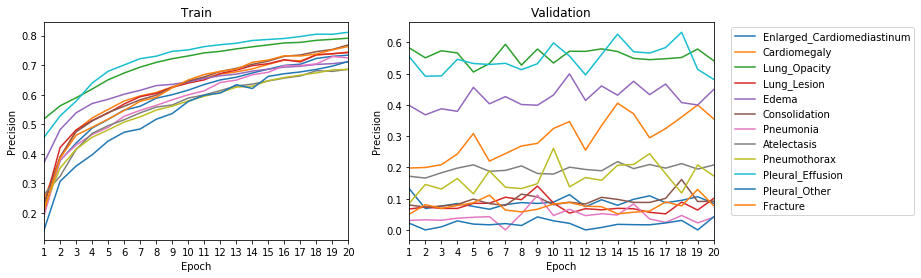


F1

▔


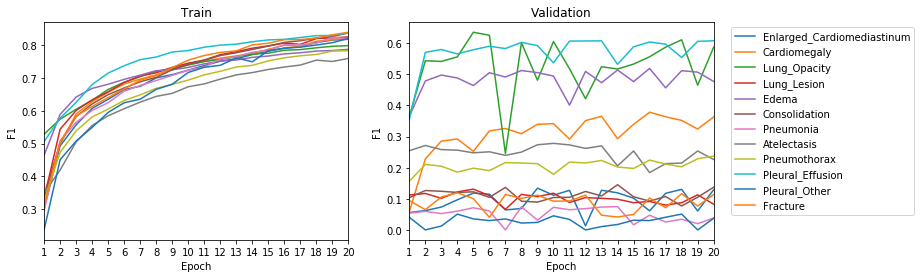


ROC AUC

▔▔▔▔


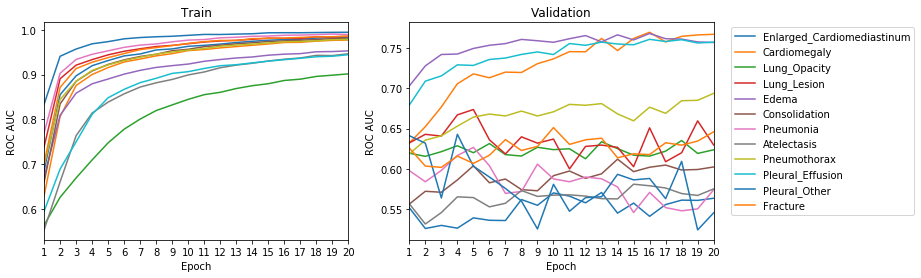


AVERAGE PRECISION

▔▔▔▔▔▔▔▔


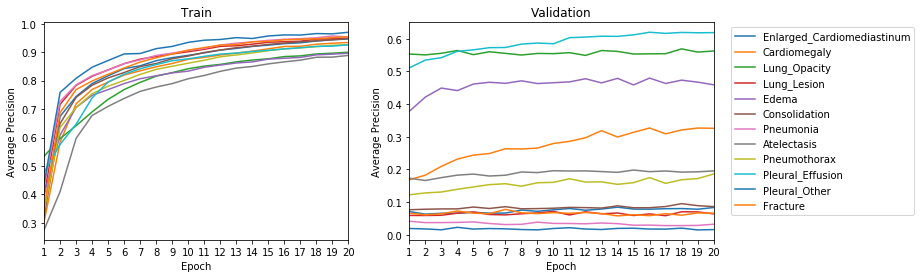

In [15]:
save_name = 'ResNet34_Oversample_L2_Sum_PosWeight_12_Targets_20_Epochs'
path= f'notebooks/ModelRuns/saved/{save_name}/'
StandardTraining.displayRunParameters(path)
metrics = StandardTraining.loadMetrics(path) 

display_args = {'metricDataSource':MetricDataSource.Both, 
                  'showCombinedMetrics':True, 
                  'showMetricDataFrame':False, 
                  'showROCCurves':False, 
                  'showPrecisionRecallCurves':False}

metrics.displayMetrics(**display_args)

progression_args = {'metricDataSource':MetricDataSource.ValidationOnly, 
                  'showAccuracyProgression':False, 
                  'showRecallProgression':True, 
                  'showPrecisionProgression':True, 
                  'showROCAUCProgression':False, 
                  'showAvgPrecisionProgression':False}

metrics.displayEpochProgression(**progression_args)

# Target Competition

The final scores were not very good.  With 20 epochs, you see the classical overfitting.  Even with over 130,000 images, it looks like the ResNet was able to memorize the dataset.  Almost all of the training Recall and ROC AUC values were in the 90% range.  

## Epoch Progression

The plots of the Epoch Progression are **extremely** telling here!  You can easily see how the training metric improves with more epochs.  But the validation sets very nicely shows the "toggling" effect.

## In order to get gains from one target, another target must sacrifice!

This makes sense.  We are training all 12 labels with the same set of weights.  Some of the diagnoses look for very different image features.  Several targets like  Lung_Opacity, Consolidation, Pneumonia and Atelectasis look for patterns in the air spaces of the lungs.  Targets like Cardiomegaly, Pneumothorax and Fracture look for silhouette shapes.

The Recall based metrics show a much strong "toggling" effect whereas Precision based metrics tend to be more stable.


# 5 Independent Models  <a class="anchor" id="5_Independent_Models"></a>

### Below are the Metrics for 5 Model runs, each with single target

In [20]:
display_args = {'metricDataSource':MetricDataSource.ValidationOnly, 
                  'showCombinedMetrics':True, 
                  'showMetricDataFrame':False, 
                  'showROCCurves':False, 
                  'showPrecisionRecallCurves':False}

for save_name in ['ResNet34_Atelectasis', 
                  'ResNet34_Cardiomegaly', 
                  'ResNet34_Consolidation', 
                  'ResNet34_Edema', 
                  'ResNet34_Pleural_Effusion']:
    path= f'notebooks/ModelRuns/saved/{save_name}/'
    metrics = StandardTraining.loadMetrics(path) 
    metrics.displayMetrics(**display_args)

▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
ResNet34_Atelectasis
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔

VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.844359
Hamming Loss,0.155641
Hamming Accuracy,0.844359
Combined Recall,1.000000
Combined Precision,0.844353
Combined F1,0.915609


▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
ResNet34_Cardiomegaly
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔

VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.879555
Hamming Loss,0.120445
Hamming Accuracy,0.879555
Combined Recall,0.964325
Combined Precision,0.905884
Combined F1,0.934191


▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
ResNet34_Consolidation
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔

VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.940857
Hamming Loss,0.059143
Hamming Accuracy,0.940857
Combined Recall,1.000000
Combined Precision,0.940857
Combined F1,0.969527


▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
ResNet34_Edema
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔

VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.777065
Hamming Loss,0.222935
Hamming Accuracy,0.777065
Combined Recall,0.995874
Combined Precision,0.777842
Combined F1,0.873457


▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
ResNet34_Pleural_Effusion
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔

VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.753458
Hamming Loss,0.246542
Hamming Accuracy,0.753458
Combined Recall,0.832552
Combined Precision,0.800572
Combined F1,0.816249


### As we can see from the results, all the scores of these independant model runs are much better then when we run a single model predicting all 5 targets


# Conclusions <a class="anchor" id="Conclusions"></a>

## The Model was not Super Critical

ResNet looked to be somewhat better than DenseNet and the custom model, but not overwhelmingly so.  This is not to say if more time was spent building different short circuits or dense blocks, we could get better performance.  But the main issue was not the ability to train.  In fact, overtraining was one of the major stumbling blocks.

##  Regularization, Image Augmentation, Oversampling Critical, but NOT Enough

The results of adding these training features was obviously very helpful, but it was not enough to overcome the competition between targets.

## Model's were able to Quickly Achieve an Overtrained State

# 12 Targets, 1 Set of Weights

It looks like training 12 separate models, one for each target might be the best way to go.  But there might be other options within a Model architecture that prevents sharing weights between targets.


# Future Areas of Exploration <a class="anchor" id="Future_Areas_of_Exploration"></a>

### Model Architectures
Because the emphasis was placed on understanding and building a framework, not as much time was spent exploring different model architectures.  A very good understanding was obtained from working with ResNet and DenseNet, but due to time constraints, no attempts were made to modify or enhance these two architectures.  

### TensorBoard
Initially, the plan was to use TensorBoard in this project.  But it was quickly found that a deeper background into the metrics associated with CNNs was needed.  In fact, this was the reason for making the emphasis on building a framework.  But there were features available in TensorBorad that would have been nice to see such as the visualization of filters and feature maps.

### Productionization
Due to time constraints, exploring the productionization of models was not done.  It would be nice to have set up an endpoint on AWS that you could post an x-ray to and return the model predictions.  Exploring how 12 separate models, one for each target, could be melded into a single API call and how updates to the end point could be made.

### A more systematic approach to parameter tuning
An attempt was made to do this more programmatically with the ModelLoop class.  But this was of limited help due to resource contention running multiple models in the same Python kernel.  Perhaps some kind of external code, i.e. C#could be used to start and tear down Python kernels so a set of models and/or parameters could be run unattended.



# Should Haves
As will all projects, looking back as what went good and what was not so good is always important.  So of the things that were missed, that could be cleaned up with a refactor could be:

- Docstrings
- Unit Tests
- Refactoring of Classes
- Better organization of folders
- Better comments in the supporting notebooks
- Better visualizations of the EDA
- Add Radiology Terminology and examples of each diagnosis
- More efficient Readme (sorry, tl:dr)


Also missing were better explanations of ResNet and DenseNet.  Some educational notebooks would have been great to add.


# Final Thoughts <a class="anchor" id="Final_Thoughts"></a>

This journey was extremely helpful.  At the beginning of the project, a huge amount of time was spent trying to figure out things like:
- Why shapes between layers or in metrics did not match up
- Differences between Binary Classification, multi-class and multi-label problems
- What loss functions where used and why the loss function didn't mate with the model outputs
- etc, etc, etc

But by the end of the project, most of not all of these types of things became second nature.  Deciding to extend the framework to allow only a single target was a relatively late addition to the project, but with the experience gained, this was a quick change with only minimal time spent figuring out any bugs.  

In hindsight, this became the goal.  To gain the understanding and experience so that tackling these types of problems in the real world will be a much more efficient and effective process.

Also, the two educational notebooks proved to be invaluable.  Understanding some of the internals of PyTorch and the fundamentals of Neural Networks gave the needed background to approach this type of problem solving.
